# GP Simulated dataset analysis using G2G, and comparing against CellAlign DTW alignment

In [12]:
import torch
import gpytorch
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import regex as re
from tqdm import tqdm
import pickle
import anndata
import os,sys,inspect
import VisualUtils 
import anndata
import time
import scipy.sparse
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 

# new source imports 
import Main 
import ClusterUtils
import SimulationExperimentAnalyser
import warnings
import pickle
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
anndata.__version__

'0.8.0'

In [13]:
torch.cuda.get_device_name( torch.cuda.current_device())

'Tesla T4'

In [14]:
# Load simulated datasets
drive_dir = '../GOOGLE_DRIVE_MOUNT/OrgAlign/SimulatedData_for_G2G/all_simulated_datasets_07012023/'
with open(drive_dir+'matched_datasets.pkl', 'rb') as f:
    matched_datasets = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.25.pkl', 'rb') as f:
    divergence_simulated_datasets_25 = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.5.pkl', 'rb') as f:
    divergence_simulated_datasets_05 = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.75.pkl', 'rb') as f:
    divergence_simulated_datasets_75 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.25.pkl', 'rb') as f:
    convergence_simulated_datasets_25 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.5.pkl', 'rb') as f:
    convergence_simulated_datasets_05 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.75.pkl', 'rb') as f:
    convergence_simulated_datasets_75 = pickle.load(f)
    
T_f = torch.tensor(np.linspace(0,1,300,dtype=np.float64))  # specify time points 
# ========================================================================= LOADING CP data for DIVERGENCE AND CONVERGENCE 
# To examine the change point branching kernel to determine the approx bifurcation start point and expected range
with open(drive_dir+'/CP_05.pkl', 'rb') as f:
    CP_05 = pickle.load(f)
with open(drive_dir+'/CP_25.pkl', 'rb') as f:
    CP_25 = pickle.load(f)
with open(drive_dir+'/CP_75.pkl', 'rb') as f:
    CP_75 = pickle.load(f)
CP_75 = pd.DataFrame(CP_75.numpy()) 
CP_05 = pd.DataFrame(CP_05.numpy()) 
CP_25 = pd.DataFrame(CP_25.numpy()) 

#plot_simulated_dataset(matched_datasets[0:8],T_f)
# Taking 100 genes from each pattern class
matched_datasets = matched_datasets[0:500]
divergence_simulated_datasets_25 = divergence_simulated_datasets_25[0:500]
divergence_simulated_datasets_05 = divergence_simulated_datasets_05[0:500]
divergence_simulated_datasets_75 = divergence_simulated_datasets_75[0:500]
convergence_simulated_datasets_25 = convergence_simulated_datasets_25[0:500]
convergence_simulated_datasets_05 = convergence_simulated_datasets_05[0:500]
convergence_simulated_datasets_75 = convergence_simulated_datasets_75[0:500]

divergence_simulated_datasets =  divergence_simulated_datasets_05 + divergence_simulated_datasets_25 + divergence_simulated_datasets_75
convergence_simulated_datasets = convergence_simulated_datasets_05 + convergence_simulated_datasets_25 + convergence_simulated_datasets_75
simulated_data = divergence_simulated_datasets + matched_datasets + convergence_simulated_datasets
pattern_labels = list(np.repeat('Divergence_05', len(divergence_simulated_datasets_05))) + list(np.repeat('Divergence_025', len(divergence_simulated_datasets_25))) + list(np.repeat('Divergence_075', len(divergence_simulated_datasets_75))) + list(np.repeat('AllMatch', len(matched_datasets))) + list(np.repeat('Convergence_05', len(convergence_simulated_datasets_05))) + list(np.repeat('Convergence_025', len(convergence_simulated_datasets_25))) + list(np.repeat('Convergence_075', len(convergence_simulated_datasets_75)))# + list(np.repeat('Crossing', len(cross_datasets)))

def convert2adata(simulated_datasets,T_f, tag, write=False):
    # if const_std mode, G2G uses a constant of std=0.1 for all time points 
    n_sim_genes = len(simulated_datasets) 
    r_df = []
    q_df = []
    time = T_f.detach().numpy()
    
    for dataset in simulated_datasets:
        r_df.append( dataset[0])
        q_df.append( dataset[1])
    r_df = pd.DataFrame(r_df).transpose() 
    q_df = pd.DataFrame(q_df).transpose() 
    r_df.columns = np.asarray(['Gene' + str(x) for x in np.arange(n_sim_genes)]) 
    q_df.columns = r_df.columns
    gene_list = list(r_df.columns)

    adata_ref = anndata.AnnData(X=scipy.sparse.csr_matrix((r_df)))
    adata_ref.var_names = r_df.columns
    adata_ref.obs_names = r_df.index
    adata_ref.obs['time'] = time
    adata_query = anndata.AnnData(X=scipy.sparse.csr_matrix(q_df))
    adata_query.var_names = q_df.columns
    adata_query.obs_names = q_df.index
    adata_query.obs['time'] = time
    
    if(write):
        dataset_dir = 'SimulationData/'
        adata_ref.write_h5ad(  dataset_dir   + 'ref_'   + tag+'.h5ad')
        adata_query.write_h5ad(dataset_dir   + 'query_' + tag+'.h5ad')

    return adata_ref, adata_query

def plot_simulated_dataset(simulated_dataset, T_f, figsize = (15,4)):
    l = len(simulated_dataset)
    ncol = 4
    nrow = int(np.ceil(l/ncol)) 
    plt.subplots(nrow,ncol,figsize=figsize) 
    k=1
    for pair in simulated_dataset:
        plt.subplot(nrow,ncol,k)
        sb.scatterplot(x=T_f,y=pair[0], color='midnightblue')
        sb.scatterplot(x=T_f,y=pair[1], color='forestgreen')
        k=k+1
    plt.tight_layout()

def plotTimeSeries(al_obj, refQueryAlignerObj, plot_cells = False, plot_mean_trend= False):
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plotTimeSeriesAlignment(al_obj) 
        plt.subplot(1,3,2)
        max_val = np.max([np.max(np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene])), np.max(np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]))])
        min_val = np.min([np.min(np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene])), np.min(np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]))])
        g = sb.scatterplot(x=refQueryAlignerObj.query_time, y=np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]), alpha=0.7, color = 'midnightblue', legend=False,linewidth=0.3, s=20)  
        plt.title('Query')
        plt.ylim([min_val-0.5,max_val+0.5])
        plt.subplot(1,3,3)
        g = sb.scatterplot(x=refQueryAlignerObj.ref_time, y=np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene]), color = 'forestgreen', alpha=0.7, legend=False,linewidth=0.3,s=20 ) 
        plt.title('Reference')
        plt.ylim([min_val-0.5,max_val+0.5])
        
def plotTimeSeriesAlignment(al_obj):  
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
        al_obj.plot_mean_trends() 
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=0.6)

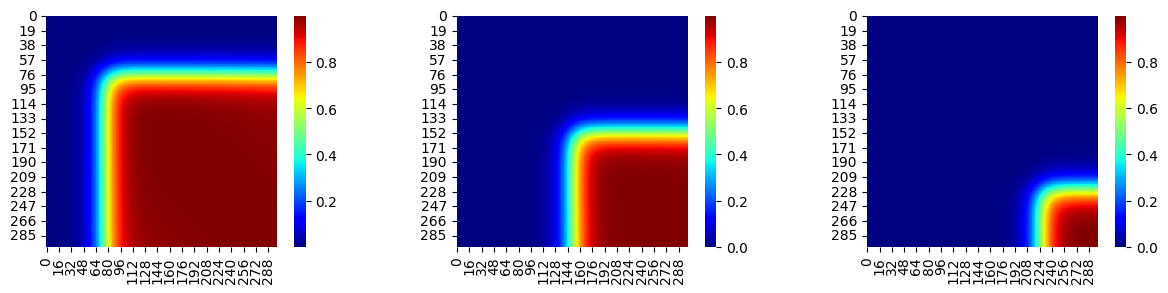

In [6]:
plt.subplots(1,3, figsize=(15,3))
plt.subplot(1,3,1)
sb.heatmap(CP_25, square=True, cmap='jet') 
plt.subplot(1,3,2)
sb.heatmap(CP_05, square=True, cmap='jet') 
plt.subplot(1,3,3)
sb.heatmap(CP_75, square=True, cmap='jet') 
plt.savefig('MS_FIGS/SimulationExperiments/ChangePointKw.png')

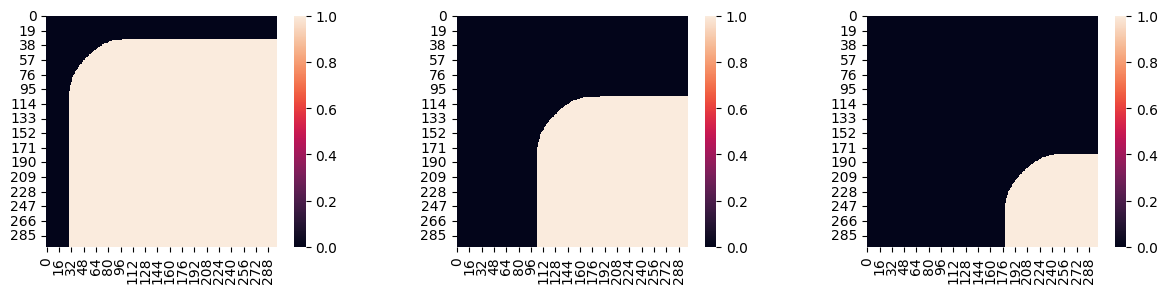

In [7]:
plt.subplots(1,3, figsize=(15,3))
plt.subplot(1,3,1)
a = pd.DataFrame(CP_25 > 0.01) 
sb.heatmap(a, square=True) 
plt.subplot(1,3,2)
a = pd.DataFrame(CP_05 > 0.01) 
sb.heatmap(a, square=True) 
plt.subplot(1,3,3)
a = pd.DataFrame(CP_75 > 0.01) 
sb.heatmap(a, square=True) 
plt.savefig('MS_FIGS/SimulationExperiments/ChangePointKw2.png')

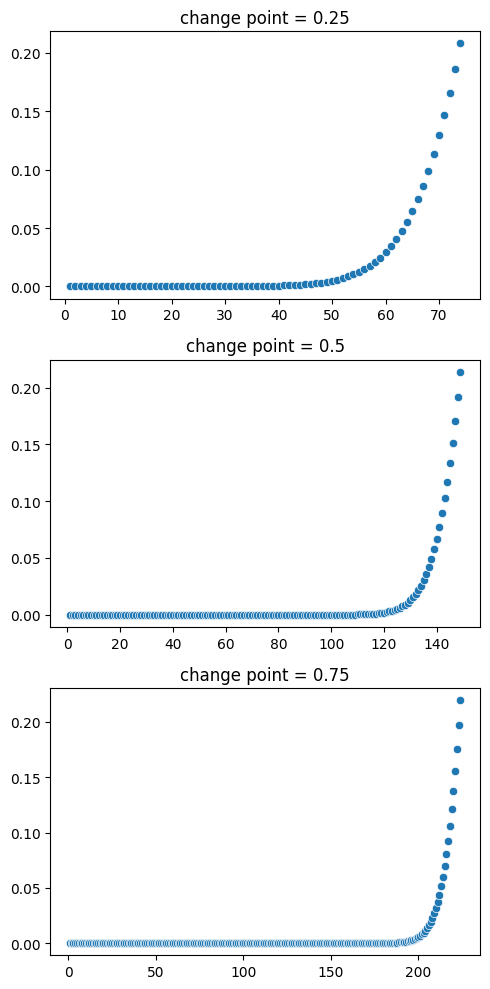

In [12]:


t1 = []
for i in range(1,75):
    t1.append(np.max(np.asmatrix(CP_25)[0:i,0:i]) )
t2 = []
for i in range(1,150):
    t2.append(np.max(np.asmatrix(CP_05)[0:i,0:i]) )
t3 = []
for i in range(1,225):
    t3.append(np.max(np.asmatrix(CP_75)[0:i,0:i]))
plt.subplots(1,3, figsize=(5,10))
plt.subplot(3,1,1)
plt.title('change point = 0.25')
sb.scatterplot(x=np.arange(1,75),y=t1)
plt.subplot(3,1,2)
plt.title('change point = 0.5')
sb.scatterplot(x=np.arange(1,150),y=t2)
plt.subplot(3,1,3)
plt.title('change point = 0.75')
sb.scatterplot(x=np.arange(1,225),y=t3)
plt.tight_layout()
plt.savefig('MS_FIGS/SimulationExperiments/Change_point_kernel_var_change_points.pdf')

# Grid search for optimal state machine params

# trying max n points for optimal binning = 15
Optimal equal number of bins for R and Q =  15


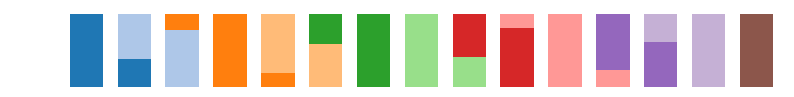

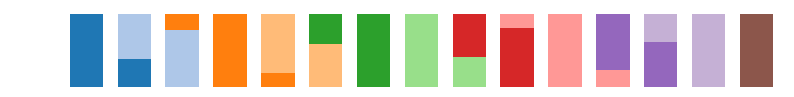

In [18]:
def run_g2g(adata_ref, adata_query, N_BINS, vs, STATE_PARAMS, optimal_binning=True):
    aligner = Main.RefQueryAligner(adata_ref, adata_query, adata_ref.var_names, N_BINS)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = STATE_PARAMS  
    aligner.optimal_binning = optimal_binning
    if(optimal_binning):
        aligner.opt_binning_S = vs.optimal_bining_S
        aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs()
    return aligner

def test_stat(aligner):
    SimExperimenter = SimulationExperimentAnalyser.SimulationExperimenter(adata_ref, adata_query, aligner, CP_25, CP_05, CP_75, pattern_map )
    inaccuracy_rates = {}
    accuracy_results = SimExperimenter.compute_divergence_convergence_statistics(print_stat=False)
    for PATTERN in [ 'Convergence_025', 'Convergence_05', 'Convergence_075','Divergence_025', 'Divergence_05', 'Divergence_075']:
        n_tot_alignments = accuracy_results[PATTERN].shape[0]
        n_expected_patterns = accuracy_results[PATTERN][accuracy_results[PATTERN].status == 'expected_pattern'].shape[0]
        #print(PATTERN,':', (n_expected_patterns*100/n_tot_alignments),'%')
        
        inaccuracy_rates[PATTERN] = np.round(100-(n_expected_patterns*100/n_tot_alignments),4)
    
    inaccuracy_rates['AllMatch'] = SimExperimenter.compute_match_statistics(existing_method_df=None, existing_method=False, print_stat=False)
    del SimExperimenter
    return inaccuracy_rates

vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=15, 
                                        ANNOTATION_COLNAME='class', optimal_binning=False, PLOT=False)

In [33]:
P_mm = 0.99
params= []
all_experiment_results = []

for P_ii in np.linspace(0.1,0.9,9):
    P_ii = np.round(P_ii,2)
    for P_mi in np.linspace(0.1,0.9,9): 
        P_mi = np.round(P_mi,2)
        if(P_ii + P_mi < 1.0):
            STATE_PARAMS = [P_mm, P_ii, P_mi]
            aligner = run_g2g(adata_ref, adata_query, N_BINS=15, vs = vs, STATE_PARAMS = STATE_PARAMS, optimal_binning=True)
            result = test_stat(aligner)
            print(STATE_PARAMS,result )
            all_experiment_results.append(result)
            params.append(STATE_PARAMS)
            del aligner

WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.1, 0.1] {'Convergence_025': 16.8, 'Convergence_05': 33.0, 'Convergence_075': 100.0, 'Divergence_025': 0.6, 'Divergence_05': 1.6, 'Divergence_075': 0.6, 'AllMatch': 3.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.1, 0.2] {'Convergence_025': 2.4, 'Convergence_05': 12.6, 'Convergence_075': 38.0, 'Divergence_025': 0.6, 'Divergence_05': 0.8, 'Divergence_075': 0.6, 'AllMatch': 3.0}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.1, 0.3] {'Convergence_025': 0.6, 'Convergence_05': 4.8, 'Convergence_075': 11.6, 'Divergence_025': 0.6, 'Divergence_05': 0.6, 'Divergence_075': 0.2, 'AllMatch': 2.8}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.1, 0.4] {'Convergence_025': 0.6, 'Convergence_05': 1.6, 'Convergence_075': 5.2, 'Divergence_025': 0.4, 'Divergence_05': 0.4, 'Divergence_075': 0.2, 'AllMatch': 2.2}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.1, 0.5] {'Convergence_025': 0.6, 'Convergence_05': 1.0, 'Convergence_075': 2.6, 'Divergence_025': 0.4, 'Divergence_05': 0.0, 'Divergence_075': 0.2, 'AllMatch': 2.2}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.1, 0.6] {'Convergence_025': 0.8, 'Convergence_05': 1.6, 'Convergence_075': 1.8, 'Divergence_025': 0.4, 'Divergence_05': 0.0, 'Divergence_075': 0.0, 'AllMatch': 1.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.1, 0.7] {'Convergence_025': 0.8, 'Convergence_05': 1.8, 'Convergence_075': 0.8, 'Divergence_025': 0.6, 'Divergence_05': 0.2, 'Divergence_075': 0.0, 'AllMatch': 1.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.1, 0.8] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 99.8, 'Divergence_075': 99.8, 'AllMatch': 0.2}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.2, 0.1] {'Convergence_025': 0.6, 'Convergence_05': 6.6, 'Convergence_075': 30.0, 'Divergence_025': 0.6, 'Divergence_05': 0.6, 'Divergence_075': 0.0, 'AllMatch': 2.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.2, 0.2] {'Convergence_025': 0.6, 'Convergence_05': 2.2, 'Convergence_075': 8.2, 'Divergence_025': 0.4, 'Divergence_05': 0.4, 'Divergence_075': 0.2, 'AllMatch': 2.2}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.2, 0.3] {'Convergence_025': 0.6, 'Convergence_05': 1.0, 'Convergence_075': 3.0, 'Divergence_025': 0.4, 'Divergence_05': 0.0, 'Divergence_075': 0.0, 'AllMatch': 2.2}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.2, 0.4] {'Convergence_025': 0.8, 'Convergence_05': 1.6, 'Convergence_075': 1.6, 'Divergence_025': 0.4, 'Divergence_05': 0.0, 'Divergence_075': 0.0, 'AllMatch': 1.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.2, 0.5] {'Convergence_025': 0.8, 'Convergence_05': 1.6, 'Convergence_075': 1.6, 'Divergence_025': 0.4, 'Divergence_05': 0.0, 'Divergence_075': 0.0, 'AllMatch': 1.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.2, 0.6] {'Convergence_025': 36.8, 'Convergence_05': 12.0, 'Convergence_075': 4.4, 'Divergence_025': 3.8, 'Divergence_05': 11.6, 'Divergence_075': 37.6, 'AllMatch': 0.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.2, 0.7] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.3, 0.1] {'Convergence_025': 0.6, 'Convergence_05': 1.2, 'Convergence_075': 2.4, 'Divergence_025': 0.4, 'Divergence_05': 0.0, 'Divergence_075': 0.0, 'AllMatch': 2.2}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.3, 0.2] {'Convergence_025': 0.6, 'Convergence_05': 1.0, 'Convergence_075': 2.4, 'Divergence_025': 0.4, 'Divergence_05': 0.0, 'Divergence_075': 0.0, 'AllMatch': 1.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.3, 0.3] {'Convergence_025': 0.6, 'Convergence_05': 1.0, 'Convergence_075': 2.4, 'Divergence_025': 0.4, 'Divergence_05': 0.0, 'Divergence_075': 0.0, 'AllMatch': 1.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.3, 0.4] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.3, 0.5] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.3, 0.6] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.4, 0.1] {'Convergence_025': 0.6, 'Convergence_05': 3.0, 'Convergence_075': 5.2, 'Divergence_025': 0.4, 'Divergence_05': 0.4, 'Divergence_075': 0.0, 'AllMatch': 1.2}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:02<?, ?it/s]

[0.99, 0.4, 0.2] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.4, 0.3] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.4, 0.4] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.4, 0.5] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.5, 0.1] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.5, 0.2] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.5, 0.3] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.5, 0.4] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.6, 0.1] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.6, 0.2] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.6, 0.3] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.7, 0.1] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.7, 0.2] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.99, 0.8, 0.1] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 0.6}


In [48]:
stat_df = pd.DataFrame(all_experiment_results) 
stat_df['mean_inaccuracy_rate'] = stat_df.mean(axis=1)/7
stat_df['params'] = params
stat_df = stat_df.sort_values('mean_inaccuracy_rate')

In [49]:
stat_df


Convergence_025  Convergence_05  Convergence_075  Divergence_025  \
6               0.8             1.8              0.8             0.6   
17              0.6             1.0              2.4             0.4   
12              0.8             1.6              1.6             0.4   
11              0.8             1.6              1.6             0.4   
16              0.6             1.0              2.4             0.4   
5               0.8             1.6              1.8             0.4   
15              0.6             1.2              2.4             0.4   
4               0.6             1.0              2.6             0.4   
10              0.6             1.0              3.0             0.4   
3               0.6             1.6              5.2             0.4   
21              0.6             3.0              5.2             0.4   
9               0.6             2.2              8.2             0.4   
2               0.6             4.8             11.6             0.6   
8               0.6             6.6             30.0             0.6   
1               2.4            12.6             38.0             0.6   
13             36.8            12.0              4.4             3.8   
0              16.8            33.0            100.0             0.6   
7             100.0           100.0            100.0           100.0   
18            100.0           100.0            100.0           100.0   
19            100.0           100.0            100.0           100.0   
20            100.0           100.0            100.0           100.0   
14            100.0           100.0            100.0           100.0   
34            100.0           100.0            100.0           100.0   
33            100.0           100.0            100.0           100.0   
32            100.0           100.0            100.0           100.0   
31            100.0           100.0            100.0           100.0   
30            100.0           100.0            100.0           100.0   
29            100.0           100.0            100.0           100.0   
26            100.0           100.0            100.0           100.0   
27            100.0           100.0            100.0           100.0   
25            100.0           100.0            100.0           100.0   
24            100.0           100.0            100.0           100.0   
23            100.0           100.0            100.0           100.0   
22            100.0           100.0            100.0           100.0   
28            100.0           100.0            100.0           100.0   
35            100.0           100.0            100.0           100.0   

    Divergence_05  Divergence_075  AllMatch  mean_inaccuracy_rate  \
6             0.2             0.0       1.4              0.114286   
17            0.0             0.0       1.4              0.118367   
12            0.0             0.0       1.4              0.118367   
11            0.0             0.0       1.6              0.122449   
16            0.0             0.0       1.6              0.122449   
5             0.0             0.0       1.6              0.126531   
15            0.0             0.0       2.2              0.138776   
4             0.0             0.2       2.2              0.142857   
10            0.0             0.0       2.2              0.146939   
3             0.4             0.2       2.2              0.216327   
21            0.4             0.0       1.2              0.220408   
9             0.4             0.2       2.2              0.289796   
2             0.6             0.2       2.8              0.432653   
8             0.6             0.0       2.6              0.836735   
1             0.8             0.6       3.0              1.183673   
13           11.6            37.6       0.4              2.175510   
0             1.6             0.6       3.4              3.183673   
7            99.8            99.8       0.2             12.240816   
18          100.0           

In [50]:
# Fixing the optimal Pii and Pmi parameters and finding the optimal Pmm
for P_mm in np.linspace(0.1,0.9,9):
    P_mm = np.round(P_mm,2)
    STATE_PARAMS = [P_mm, 0.1, 0.7]
    aligner = run_g2g(adata_ref, adata_query, N_BINS=15, vs = vs, STATE_PARAMS = STATE_PARAMS, optimal_binning=True)
    result = test_stat(aligner)
    print(STATE_PARAMS,result )
    all_experiment_results.append(result)
    params.append(STATE_PARAMS)
    del aligner

WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.1, 0.1, 0.7] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 100.0, 'Divergence_025': 100.0, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 100.0}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.2, 0.1, 0.7] {'Convergence_025': 100.0, 'Convergence_05': 100.0, 'Convergence_075': 59.0, 'Divergence_025': 86.4, 'Divergence_05': 100.0, 'Divergence_075': 100.0, 'AllMatch': 100.0}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.3, 0.1, 0.7] {'Convergence_025': 84.8, 'Convergence_05': 45.8, 'Convergence_075': 23.2, 'Divergence_025': 37.4, 'Divergence_05': 46.4, 'Divergence_075': 82.2, 'AllMatch': 62.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.4, 0.1, 0.7] {'Convergence_025': 53.2, 'Convergence_05': 31.6, 'Convergence_075': 15.6, 'Divergence_025': 20.2, 'Divergence_05': 25.8, 'Divergence_075': 47.2, 'AllMatch': 23.6}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.5, 0.1, 0.7] {'Convergence_025': 29.4, 'Convergence_05': 22.8, 'Convergence_075': 10.2, 'Divergence_025': 11.0, 'Divergence_05': 15.8, 'Divergence_075': 22.6, 'AllMatch': 13.4}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.6, 0.1, 0.7] {'Convergence_025': 14.6, 'Convergence_05': 17.6, 'Convergence_075': 7.8, 'Divergence_025': 5.2, 'Divergence_05': 7.6, 'Divergence_075': 8.6, 'AllMatch': 8.8}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.7, 0.1, 0.7] {'Convergence_025': 9.2, 'Convergence_05': 14.4, 'Convergence_075': 6.6, 'Divergence_025': 2.6, 'Divergence_05': 3.0, 'Divergence_075': 3.8, 'AllMatch': 5.8}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.8, 0.1, 0.7] {'Convergence_025': 6.6, 'Convergence_05': 12.0, 'Convergence_075': 5.6, 'Divergence_025': 0.8, 'Divergence_05': 1.4, 'Divergence_075': 1.4, 'AllMatch': 4.2}
WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

[0.9, 0.1, 0.7] {'Convergence_025': 3.8, 'Convergence_05': 8.6, 'Convergence_075': 3.2, 'Divergence_025': 0.6, 'Divergence_05': 0.6, 'Divergence_075': 0.6, 'AllMatch': 3.2}


In [51]:
prev_stat_df = stat_df.copy() 

In [53]:
stat_df = pd.DataFrame(all_experiment_results) 
stat_df['mean_inaccuracy_rate'] = stat_df.mean(axis=1)/7
stat_df['params'] = params
stat_df = stat_df.sort_values('mean_inaccuracy_rate')

In [54]:
stat_df

Convergence_025  Convergence_05  Convergence_075  Divergence_025  \
6               0.8             1.8              0.8             0.6   
17              0.6             1.0              2.4             0.4   
12              0.8             1.6              1.6             0.4   
16              0.6             1.0              2.4             0.4   
11              0.8             1.6              1.6             0.4   
5               0.8             1.6              1.8             0.4   
15              0.6             1.2              2.4             0.4   
4               0.6             1.0              2.6             0.4   
10              0.6             1.0              3.0             0.4   
3               0.6             1.6              5.2             0.4   
21              0.6             3.0              5.2             0.4   
9               0.6             2.2              8.2             0.4   
44              3.8             8.6              3.2             0.6   
2               0.6             4.8             11.6             0.6   
43              6.6            12.0              5.6             0.8   
8               0.6             6.6             30.0             0.6   
42              9.2            14.4              6.6             2.6   
1               2.4            12.6             38.0             0.6   
41             14.6            17.6              7.8             5.2   
13             36.8            12.0              4.4             3.8   
40             29.4            22.8             10.2            11.0   
0              16.8            33.0            100.0             0.6   
39             53.2            31.6             15.6            20.2   
38             84.8            45.8             23.2            37.4   
7             100.0           100.0            100.0           100.0   
19            100.0           100.0            100.0           100.0   
14            100.0           100.0            100.0           100.0   
18            100.0           100.0            100.0           100.0   
20            100.0           100.0            100.0           100.0   
35            100.0           100.0            100.0           100.0   
34            100.0           100.0            100.0           100.0   
32            100.0           100.0            100.0           100.0   
33            100.0           100.0            100.0           100.0   
30            100.0           100.0            100.0           100.0   
29            100.0           100.0            100.0           100.0   
28            100.0           100.0            100.0           100.0   
27            100.0           100.0            100.0           100.0   
26            100.0           100.0            100.0           100.0   
25            100.0           100.0            100.0           100.0   
24            100.0           100.0            100.0           100.0   
23            100.0           100.0            100.0           100.0   
31            100.0           100.0            100.0           100.0   
22            100.0           100.0            100.0           100.0   
37            100.0           100.0             59.0            86.4   
36            100.0           100.0            100.0           100.0   

    Divergence_05  Divergence_075  AllMatch  mean_inaccuracy_rate  \
6             0.2             0.0       1.4              0.114286   
17            0.0             0.0       1.4              0.118367   
12            0.0             0.0       1.4              0.118367   
16            0.0             0.0       1.6              0.122449   
11            0.0             0.0       1.6              0.122449   
5             0.0             0.0       1.6              0.126531   
15            0.0             0.0       2.2              0.138776   
4             0.0             0.2       2.2              0.142857   
10            0.0             0.0       2.2              0.146939   
3

In [56]:
#pickle.dump(stat_df, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/sismulated_dataset_optimal_param_grid_search_results.pkl', 'wb')) 

#with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/sismulated_dataset_optimal_param_grid_search_results.pkl', 'rb') as f:
#    temp = pickle.load(f)
#temp.to_csv('results/optimal_state_machine_params_grid_search_results.csv')

# Running G2G for all alignments

In [15]:
def prep(dataset, name, optimal_binning, load_aligner = False):

    adata_ref, adata_query = convert2adata(dataset, T_f, name, write=False)
    adata_ref.obs['class'] = np.asarray( adata_ref.obs['time']*10 , dtype = np.int)
    adata_query.obs['class'] = np.asarray( adata_query.obs['time']*10 , dtype = np.int)
    adata_ref.var['gene_pattern'] = pattern_labels
    adata_query.var['gene_pattern'] = pattern_labels
    
    if(load_aligner):
        with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_all_GP_simulated_data.pkl', 'rb') as f:
            aligner = pickle.load(f)
        return aligner, adata_ref, adata_query 
    
    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=15, 
                                        ANNOTATION_COLNAME='class', optimal_binning=False, PLOT=False)
    
    s_time = time.time()
    aligner = run_g2g(adata_ref, adata_query, N_BINS, vs, STATE_PARAMS, optimal_binning=True) 
    print(e_time-s_time)
    #pickle.dump(aligner_all, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_all_GP_simulated_data.pkl', 'wb')) 
    return aligner, adata_ref, adata_query 

N_BINS = 15
STATE_PARAMS = [0.99, 0.1, 0.7]
aligner_all, adata_ref, adata_query  = prep(simulated_data, 'all', optimal_binning=True, load_aligner=True)
genes = adata_ref.var_names
pattern_map = {}
for i in range(len(pattern_labels)):
    pattern_map[genes[i]] = pattern_labels[i]

In [16]:
aligner_all

In [4]:
def prep(dataset, name):

    adata_ref, adata_query = convert2adata(dataset, T_f, name, write=False)
    adata_ref.obs['class'] = np.asarray( adata_ref.obs['time']*10 , dtype = np.int)
    adata_query.obs['class'] = np.asarray( adata_query.obs['time']*10 , dtype = np.int)
    adata_ref.var['gene_pattern'] = pattern_labels
    adata_query.var['gene_pattern'] = pattern_labels
    return adata_ref, adata_query
adata_ref, adata_query = prep(simulated_data, 'all')

In [5]:
adata_ref

AnnData object with n_obs × n_vars = 300 × 3500
    obs: 'time', 'class'
    var: 'gene_pattern'

In [18]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

15

In [7]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

15

In [7]:
(87.96314406394958)/3500

0.025132326875414168

Average Alignment:  IIIDIDIDIDIIIIDDIIDDDDDDMMM


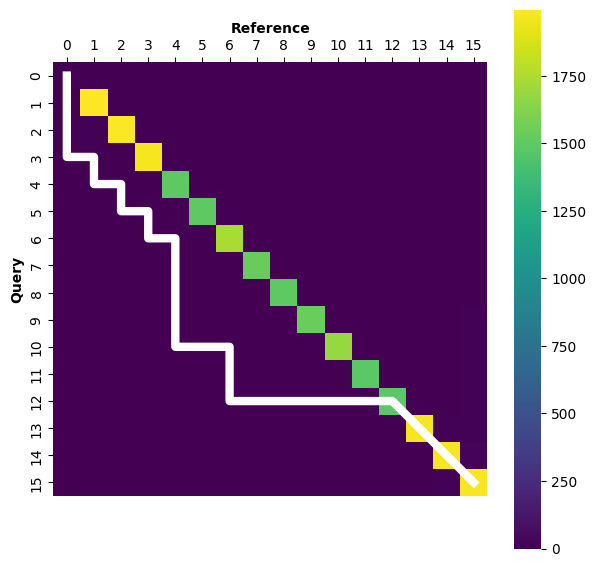

In [8]:
aligner_all.get_aggregate_alignment()

In [9]:
SimExperimenter = SimulationExperimentAnalyser.SimulationExperimenter(adata_ref, adata_query, aligner_all, CP_25, CP_05, CP_75, pattern_map )

In [8]:
SimExperimenter = SimulationExperimentAnalyser.SimulationExperimenter(adata_ref, adata_query, aligner_all, CP_25, CP_05, CP_75, pattern_map )
SimExperimenter.compute_match_statistics(existing_method_df=None, existing_method=False)

Number of false mismatched alignments  7  =  1.4 %
Number of false mismatches  14  =  0.18649260690022645 %
mean false mismatch count for an alignment =  2.0
*****


1.4

In [9]:
tr_df = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/TrAGEDy_5state_strings_nullcuttype.csv')
tr_df_mincut = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/TrAGEDy_5state_strings_minimumcut.csv')
tr_df = tr_df.set_index('Gene')
tr_df_mincut = tr_df_mincut.set_index('Gene')

In [10]:
SimExperimenter.compute_match_statistics(existing_method_df=tr_df, existing_method=True)
SimExperimenter.compute_match_statistics(existing_method_df=tr_df_mincut, existing_method=True)

Number of false mismatched alignments  159  =  31.8 %
Number of false mismatches  677  =  7.349109856708641 %
mean false mismatch count for an alignment =  4.2578616352201255
*****
Number of false mismatched alignments  167  =  33.73737373737374 %
Number of false mismatches  902  =  9.748189776288772 %
mean false mismatch count for an alignment =  5.401197604790419
*****


33.73737373737374

In [11]:
g2g_divcov_alignment_accuracy_results = SimExperimenter.compute_divergence_convergence_statistics()

Convergence_025 500 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([  4, 496]))
Convergence_05 500 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([  9, 491]))
Convergence_075 500 (array(['complete_mismatch', 'complex_pattern', 'expected_pattern'],
      dtype=object), array([  2,   2, 496]))
Divergence_025 500 (array(['complete_mismatch', 'complex_pattern', 'expected_pattern'],
      dtype=object), array([  2,   1, 497]))
Divergence_05 500 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([  1, 499]))
Divergence_075 500 (array(['expected_pattern'], dtype=object), array([500]))


In [12]:
TrAGEDyMinCut_divcov_alignment_accuracy_results = SimExperimenter.compute_divergence_convergence_statistics(existing_method=True, tr_df=tr_df_mincut) 

Convergence_025 491 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 13, 478]))
Convergence_05 493 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 19, 474]))
Convergence_075 500 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 59, 441]))
Divergence_025 42 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([30, 12]))
Divergence_05 365 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 15, 350]))
Divergence_075 382 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 12, 370]))


In [13]:
TrAGEDyNullCut_divcov_alignment_accuracy_results = SimExperimenter.compute_divergence_convergence_statistics(existing_method=True, tr_df=tr_df) 

Convergence_025 500 (array(['expected_pattern'], dtype=object), array([500]))
Convergence_05 500 (array(['complete_match', 'expected_pattern', 'swapped_pattern'],
      dtype=object), array([ 17, 440,  43]))
Convergence_075 500 (array(['complete_match', 'expected_pattern', 'swapped_pattern'],
      dtype=object), array([436,  29,  35]))
Divergence_025 500 (array(['complete_match', 'expected_pattern', 'swapped_pattern'],
      dtype=object), array([439,  27,  34]))
Divergence_05 500 (array(['complete_match', 'expected_pattern', 'swapped_pattern'],
      dtype=object), array([ 17, 440,  43]))
Divergence_075 500 (array(['expected_pattern'], dtype=object), array([500]))


Approx. bifurcation start i for cp=0.25 =  0.1
Approx. bifurcation start i for cp=0.5 =  0.35
Approx. bifurcation start i for cp=0.75 =  0.6
Expected match len for cp=0.25 =  [1.5, 3.75]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [9.0, 11.25]
Expected mismatch len for cp=0.25 =  [11.25, 13.5]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [3.75, 6.0]


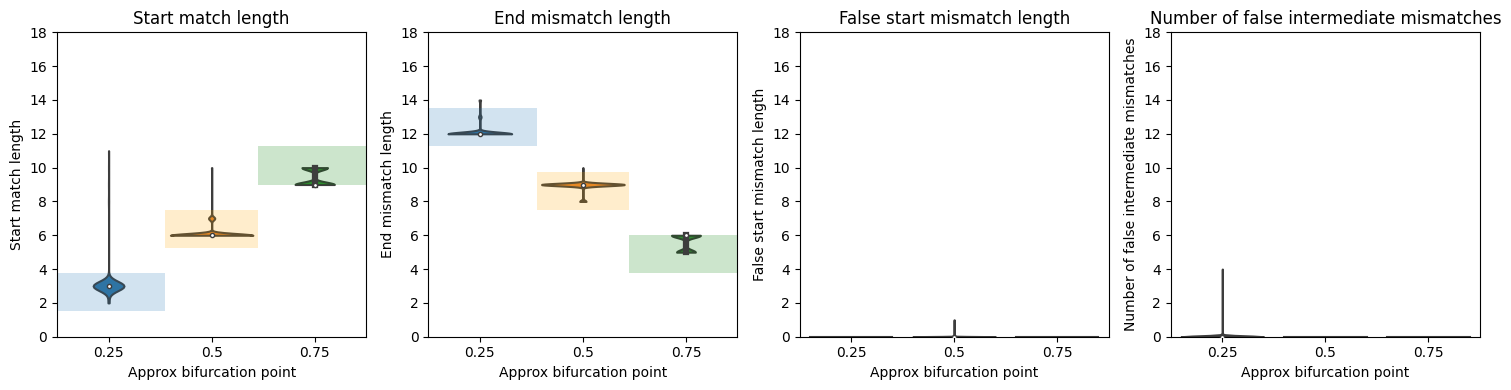

In [14]:
df = SimExperimenter.plot_validation_stat(g2g_divcov_alignment_accuracy_results, divergence=True)
#plt.savefig('MS_FIGS/SimulationExperiments/G2G_divergence_validation_plots.png')

Approx. convergent start i for cp=0.25 =  0.4
Approx. convergent start i for cp=0.5 =  0.65
Approx. convergent start i for cp=0.75 =  0.9
Expected match len for cp=0.25 =  [9.0, 11.25]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [1.5, 3.75]
Expected mismatch len for cp=0.25 =  [3.75, 6.0]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [11.25, 13.5]


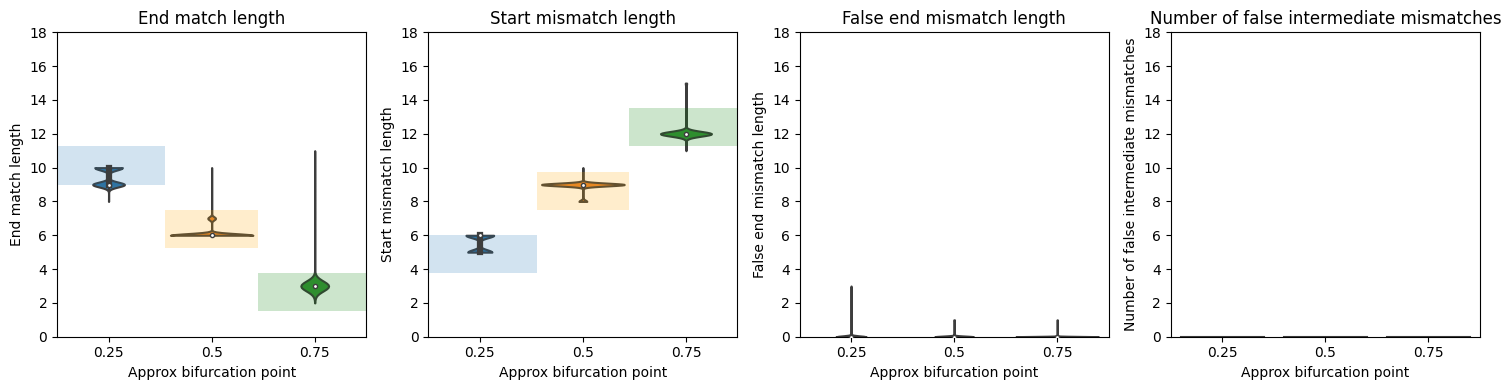

In [15]:
df = SimExperimenter.plot_validation_stat(g2g_divcov_alignment_accuracy_results, divergence=False)
#plt.savefig('MS_FIGS/SimulationExperiments/G2G_convergence_validation_plots.png')

Approx. bifurcation start i for cp=0.25 =  0.1
Approx. bifurcation start i for cp=0.5 =  0.35
Approx. bifurcation start i for cp=0.75 =  0.6
Expected match len for cp=0.25 =  [1.5, 3.75]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [9.0, 11.25]
Expected mismatch len for cp=0.25 =  [11.25, 13.5]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [3.75, 6.0]


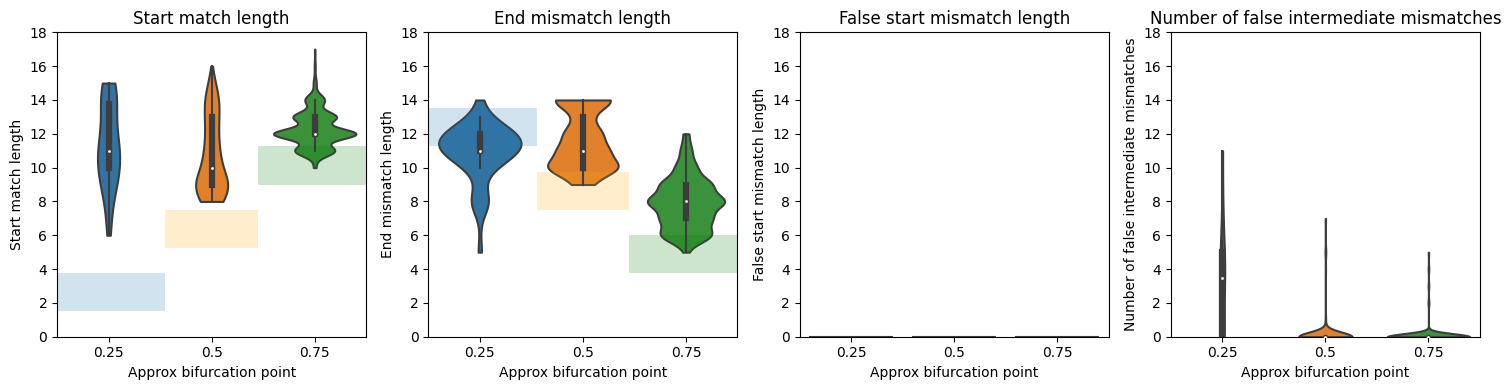

In [16]:
df = SimExperimenter.plot_validation_stat(TrAGEDyMinCut_divcov_alignment_accuracy_results, divergence=True)
#plt.savefig('MS_FIGS/SimulationExperiments/TrAGEDyMinCut_divergence_validation_plots.png')

Approx. convergent start i for cp=0.25 =  0.4
Approx. convergent start i for cp=0.5 =  0.65
Approx. convergent start i for cp=0.75 =  0.9
Expected match len for cp=0.25 =  [9.0, 11.25]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [1.5, 3.75]
Expected mismatch len for cp=0.25 =  [3.75, 6.0]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [11.25, 13.5]


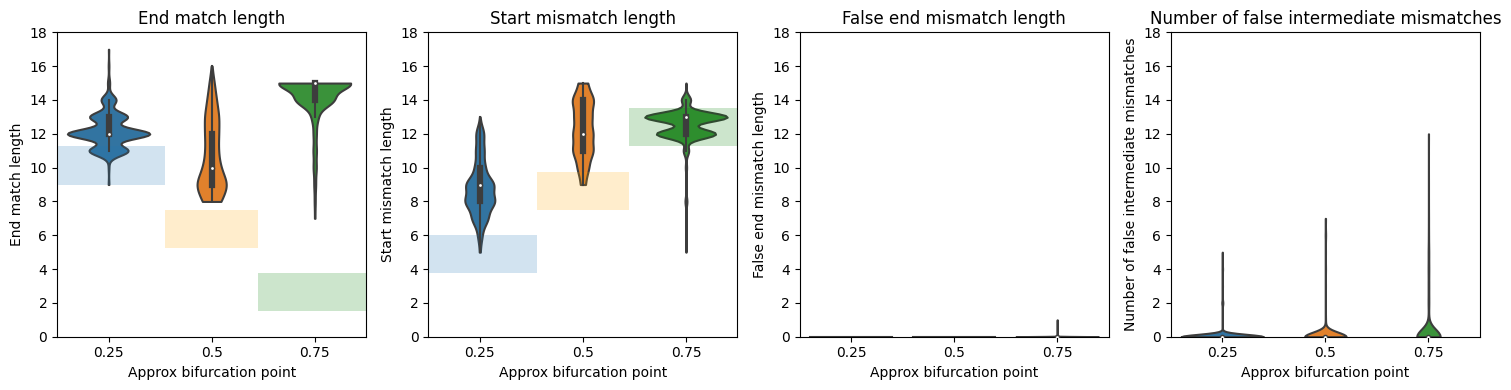

In [17]:
df = SimExperimenter.plot_validation_stat(TrAGEDyMinCut_divcov_alignment_accuracy_results, divergence=False)
#plt.savefig('MS_FIGS/SimulationExperiments/TrAGEDyMinCut_convergence_validation_plots.png')

Approx. convergent start i for cp=0.25 =  0.4
Approx. convergent start i for cp=0.5 =  0.65
Approx. convergent start i for cp=0.75 =  0.9
Expected match len for cp=0.25 =  [9.0, 11.25]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [1.5, 3.75]
Expected mismatch len for cp=0.25 =  [3.75, 6.0]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [11.25, 13.5]


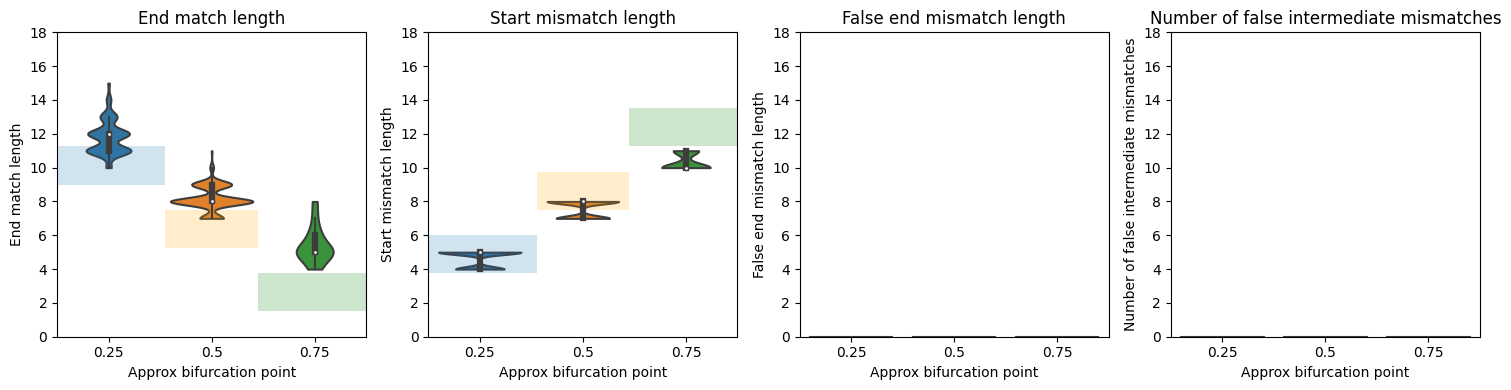

In [18]:
df = SimExperimenter.plot_validation_stat(TrAGEDyNullCut_divcov_alignment_accuracy_results, divergence=False)
#plt.savefig('MS_FIGS/SimulationExperiments/TrAGEDyNullCut_covergence_validation_plots.png')

Approx. bifurcation start i for cp=0.25 =  0.1
Approx. bifurcation start i for cp=0.5 =  0.35
Approx. bifurcation start i for cp=0.75 =  0.6
Expected match len for cp=0.25 =  [1.5, 3.75]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [9.0, 11.25]
Expected mismatch len for cp=0.25 =  [11.25, 13.5]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [3.75, 6.0]


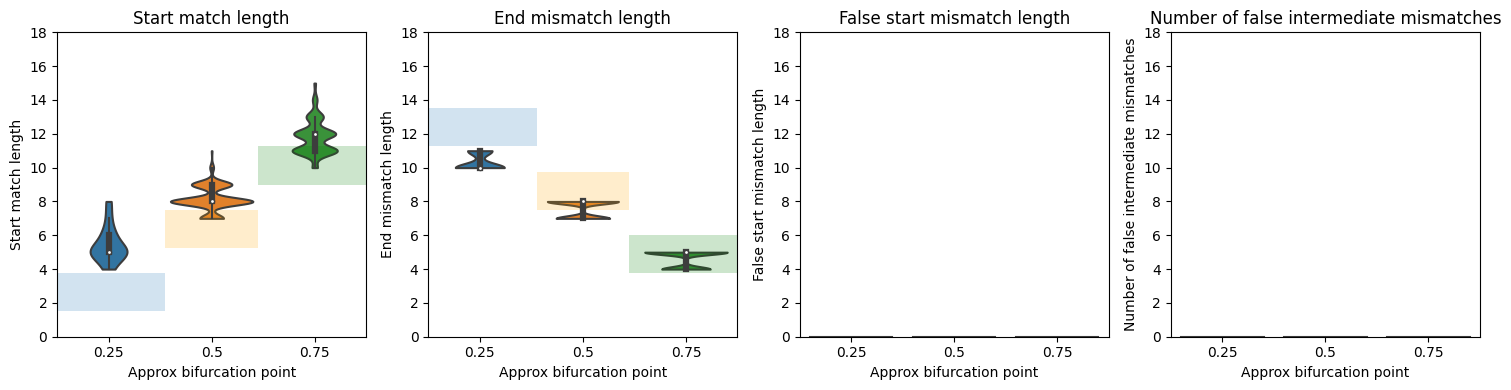

In [19]:
df = SimExperimenter.plot_validation_stat(TrAGEDyNullCut_divcov_alignment_accuracy_results, divergence=True)
#plt.savefig('MS_FIGS/SimulationExperiments/TrAGEDyNullCut_divergence_validation_plots.png')

In [27]:
temp = [] 
def test(accuracy_results, method):
    
    for PATTERN in [ 'Convergence_025', 'Convergence_05', 'Convergence_075','Divergence_025', 'Divergence_05', 'Divergence_075']:
        n_tot_alignments = accuracy_results[PATTERN].shape[0]
        n_expected_patterns = accuracy_results[PATTERN][accuracy_results[PATTERN].status == 'expected_pattern'].shape[0]
        print(PATTERN,':', round(n_expected_patterns*100/n_tot_alignments,2),'%')
        temp.append( [PATTERN, method, n_expected_patterns*100/n_tot_alignments]  )
        
print('G2G ============================ ')
test(g2g_divcov_alignment_accuracy_results, method='G2G')
print('TrAGEDy min cut============================ ')
test(TrAGEDyMinCut_divcov_alignment_accuracy_results, method='TrAGEDy_MINIMUM')
print('TrAGEDy null cut============================ ')
test(TrAGEDyNullCut_divcov_alignment_accuracy_results, method='TrAGEDy_NULL')

temp = pd.DataFrame(temp)
temp.columns = ['Pattern','Method','% of Accurate Alignment']

p = SimExperimenter.compute_match_statistics(existing_method_df=None, existing_method=False)
temp = temp.append(pd.Series(['All match','G2G',100-p] , index=temp.columns, name='18'))
p = SimExperimenter.compute_match_statistics(existing_method_df=tr_df_mincut, existing_method=True)
temp = temp.append(pd.Series(['All match','TrAGEDy_MINIMUM',100-p] , index=temp.columns, name='19'))
p =SimExperimenter.compute_match_statistics(existing_method_df=tr_df, existing_method=True)
temp = temp.append(pd.Series(['All match','TrAGEDy_NULL',100-p] , index=temp.columns, name='20'))

G2G ============================ 
Convergence_025 : 99.2 %
Convergence_05 : 98.2 %
Convergence_075 : 99.2 %
Divergence_025 : 99.4 %
Divergence_05 : 99.8 %
Divergence_075 : 100.0 %
TrAGEDy min cut============================ 
Convergence_025 : 97.35 %
Convergence_05 : 96.15 %
Convergence_075 : 88.2 %
Divergence_025 : 28.57 %
Divergence_05 : 95.89 %
Divergence_075 : 96.86 %
TrAGEDy null cut============================ 
Convergence_025 : 100.0 %
Convergence_05 : 88.0 %
Convergence_075 : 5.8 %
Divergence_025 : 5.4 %
Divergence_05 : 88.0 %
Divergence_075 : 100.0 %
Number of false mismatched alignments  7  =  1.4 %
Number of false mismatches  14  =  0.18649260690022645 %
mean false mismatch count for an alignment =  2.0
*****
Number of false mismatched alignments  167  =  33.73737373737374 %
Number of false mismatches  902  =  9.748189776288772 %
mean false mismatch count for an alignment =  5.401197604790419
*****
Number of false mismatched alignments  159  =  31.8 %
Number of false mismatc

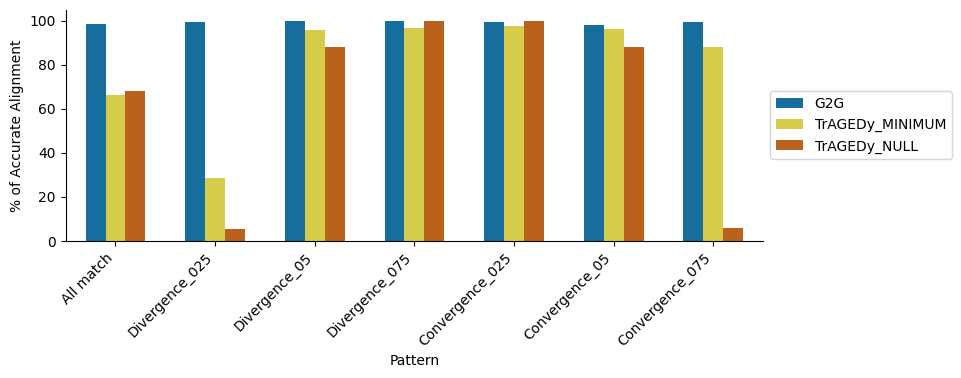

In [30]:
cat_order = ['All match', 'Divergence_025', 'Divergence_05', 'Divergence_075', 'Convergence_025', 'Convergence_05', 'Convergence_075' ]
x = sb.color_palette('colorblind')
custom_palette = sb.color_palette([x[0], x[8], x[3]])
fig, ax = plt.subplots(1,1,figsize=(9,3))
g = sb.barplot(x="Pattern", y="% of Accurate Alignment", hue="Method",data=temp, palette=custom_palette, order=cat_order,width=0.6)
sb.despine(bottom = False, left = False)
plt.xticks(rotation=45, ha='right')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MS_FIGS/SimulationExperiments/Exp1AccuracyRates.png', bbox_inches='tight')

In [31]:
#adata_ref.write_h5ad('SimulationData/adata_all_ref.h5ad')
#adata_query.write_h5ad('SimulationData/adata_all_query.h5ad')
temp

Pattern           Method  % of Accurate Alignment
0   Convergence_025              G2G                99.200000
1    Convergence_05              G2G                98.200000
2   Convergence_075              G2G                99.200000
3    Divergence_025              G2G                99.400000
4     Divergence_05              G2G                99.800000
5    Divergence_075              G2G               100.000000
6   Convergence_025  TrAGEDy_MINIMUM                97.352342
7    Convergence_05  TrAGEDy_MINIMUM                96.146045
8   Convergence_075  TrAGEDy_MINIMUM                88.200000
9    Divergence_025  TrAGEDy_MINIMUM                28.571429
10    Divergence_05  TrAGEDy_MINIMUM                95.890411
11   Divergence_075  TrAGEDy_MINIMUM                96.858639
12  Convergence_025     TrAGEDy_NULL               100.000000
13   Convergence_05     TrAGEDy_NULL                88.000000
14  Convergence_075     TrAGEDy_NULL                 5.800000
15   Divergence_025     TrAGEDy_NULL                 5.400000
16    Divergence_05     TrAGEDy_NULL                88.000000
17   Divergence_075     TrAGEDy_NULL               100.000000
18        All match              G2G                98.600000
19        All match  TrAGEDy_MINIMUM                66.262626
20        All match     TrAGEDy_NULL                68.200000

In [33]:
# CellAlign group wise cell-level high dimensional alignment
temp = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/cellalign_3state_strings_group_wise.csv')
temp
celllevel_dtw_alignments = [a.replace(' ','')  for a in temp['alignment_string']]
i=0
for a in celllevel_dtw_alignments:
    print(temp['Gene'][i], VisualUtils.color_al_str(a))
    i+=1

R_div05 - Q_div05 MMMMMVWVVVVVVVVVWWWWWWWWW
R_div25 - Q_div25 MVWVVVVVVVVVVVVVWWWWWWWWWWWWW
R_div75 - Q_div75 MMMMMMMMVWVWVVVVVWWWWW
R_match - Q_match MMMMMMMMMMMMMMVW
R_con05 - Q_con05 MWWWWWWWWMVVVVVVVVMMMMM
R_con25 - Q_con25 MWWWWMVVVMVMMMMMMMM
R_con75 - Q_con75 MWWWWWWWWWWWWMVVVVVVVVVVVVM


In [49]:
#TrAGEDy group wise cell-level high dimensional alignment
temp = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/TrAGEDy_5state_strings_group_wise_[euclidean_minimum].csv', header=None)
temp.columns = ['0','Gene','alignment_string']
temp = temp.loc[1:temp.shape[0]]
celllevel_dtw_alignments = [a.replace(' ','')  for a in temp['alignment_string']]
i=1
for a in celllevel_dtw_alignments:
    print(temp['Gene'][i], VisualUtils.color_al_str(a))
    i+=1

div05 MMMMVVVVVIIIIIDIDDDDDDDDDD
div75 MMMMMMMMVVVIIIDIDDDDDD
match MMMMMMMMMMMMMMM
con05 DDDDDDDDDIDIDIDIIIVVVVVVMMM
con25 DDDDDIDIDIDIVVVVMMMMMMM
con75 DDDDDDDDDDDDIDMMVVVVVVVVVVVV


In [51]:
#TrAGEDy group wise cell-level high dimensional alignment
temp = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/TrAGEDy_5state_strings_group_wise_[euclidean_nullcut].csv')
temp.columns = ['0','Gene','alignment_string']
celllevel_dtw_alignments = [a.replace(' ','')  for a in temp['alignment_string']]
i=0
for a in celllevel_dtw_alignments:
    print(temp['Gene'][i], VisualUtils.color_al_str(a))
    i+=1

div05 MMMMMMMMIDIDIDIDIDIDID
div25 MMMMMIDIDIDIDIDIDIDIDIDID
div75 MMMMMMMMMMMIDIDIDID
match MMMMMMMMMMMMMMM
con05 IDIDIDIDIDIDIDMMMMMMMM
con25 IDIDIDIDMMMMMMMMMMM
con75 IDIDIDIDIDIDIDIDIDIDMMMMM


# Cluster Analysis

In [31]:
alignment_strings = []
for a in aligner_all.results:
    alignment_strings.append(a.alignment_str)
len(np.unique(alignment_strings)) 

113

compute distance matrix
using levenshtein distance metric


 70%|██████▉   | 69/99 [02:23<01:02,  2.08s/it]


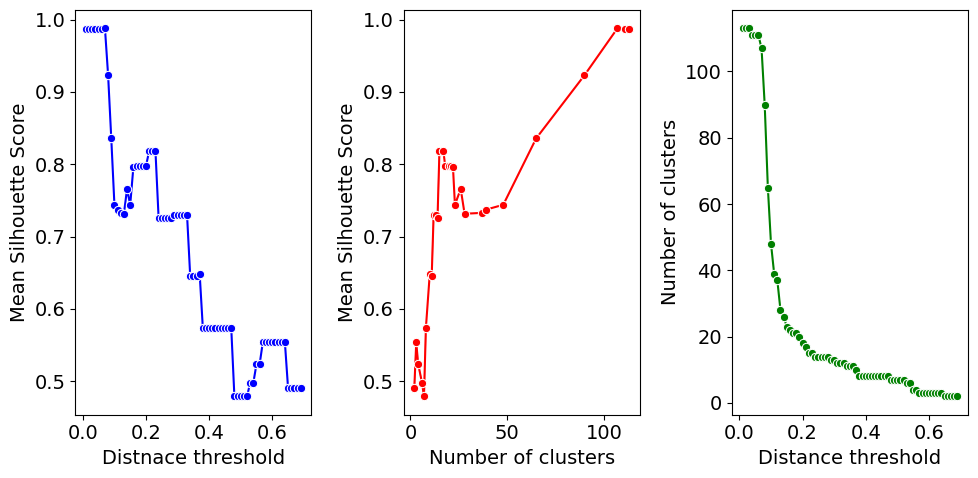

In [39]:
df = ClusterUtils.run_clustering(aligner_all, metric='levenshtein', experiment_mode=True) 
plt.savefig('MS_FIGS/SimulationExperiments/ClusterDiagnostics/G2G_levenshtein_dist_cluster_diagnostics_plot.png')

In [44]:
df.sort_values('Number of clusters')[20:50]

Distance threshold  Mean Silhouette Score  Number of clusters
50                0.51               0.478820                 7.0
51                0.52               0.478820                 7.0
46                0.47               0.573824                 8.0
45                0.46               0.573824                 8.0
44                0.45               0.573824                 8.0
43                0.44               0.573824                 8.0
42                0.43               0.573824                 8.0
41                0.42               0.573824                 8.0
40                0.41               0.573824                 8.0
39                0.40               0.573824                 8.0
38                0.39               0.573824                 8.0
37                0.38               0.573824                 8.0
36                0.37               0.648451                10.0
35                0.36               0.645549                11.0
34                0.35               0.645549                11.0
33                0.34               0.645549                11.0
32                0.33               0.730227                12.0
31                0.32               0.730227                12.0
30                0.31               0.730227                12.0
29                0.30               0.730002                13.0
28                0.29               0.730002                13.0
27                0.28               0.725304                14.0
26                0.27               0.725304                14.0
25                0.26               0.725304                14.0
24                0.25               0.725304                14.0
23                0.24               0.725304                14.0
22                0.23               0.818064                15.0
21                0.22               0.818064                15.0
20                0.21               0.818234                17.0
19                0.20               0.797628                18.0

compute distance matrix
using hamming distance metric


 71%|███████   | 70/99 [00:27<00:11,  2.55it/s]


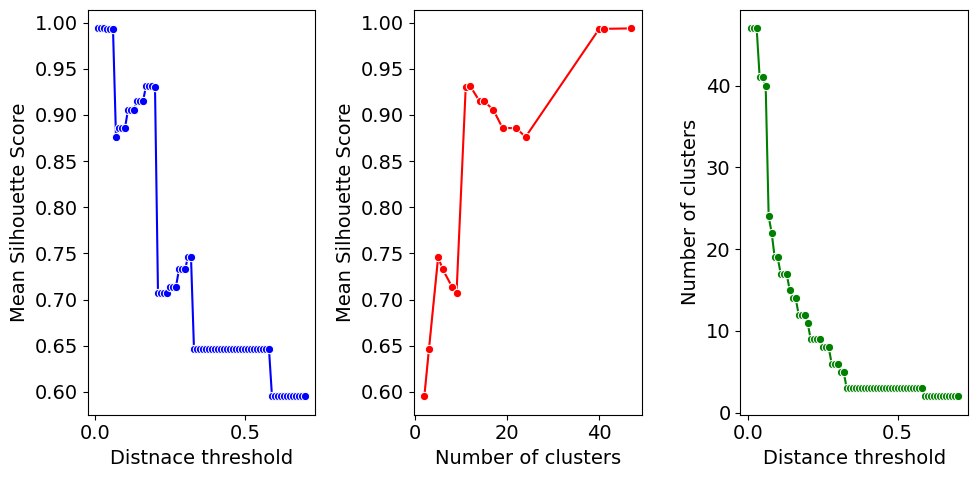

In [37]:
df = ClusterUtils.run_clustering(aligner_all, metric='hamming', experiment_mode=True) 
plt.savefig('MS_FIGS/SimulationExperiments/ClusterDiagnostics/G2G_hamming_dist_cluster_diagnostics_plot.png')

In [13]:
#df.sort_values('Number of clusters')[30:70]

In [38]:
df

Distance threshold  Mean Silhouette Score  Number of clusters
0                 0.01               0.993714                47.0
1                 0.02               0.993714                47.0
2                 0.03               0.993714                47.0
3                 0.04               0.993248                41.0
4                 0.05               0.993248                41.0
..                 ...                    ...                 ...
65                0.66               0.595144                 2.0
66                0.67               0.595144                 2.0
67                0.68               0.595144                 2.0
68                0.69               0.595144                 2.0
69                0.70               0.595144                 2.0

[70 rows x 3 columns]

In [49]:
ClusterUtils.run_clustering(aligner_all, metric='hamming', DIST_THRESHOLD=0.17) 

compute distance matrix
using hamming distance metric
run agglomerative clustering |  0.17
silhouette_score:  0.9310901260641011


In [50]:
ClusterUtils.print_cluster_average_alignments(aligner_all)

cluster:  0 IIIDIDIDIDDDMMMMMMMMM 501
cluster:  1 MMMMMMIIIIIDIDIDIIDDDDDD 499
cluster:  2 IIIDIDIDIDIIIIIIDDDDDDDMMMW 5
cluster:  3 IIIDIDIDIDIIIIDDDDDDDDMMMVV 10
cluster:  4 MMMIIIIIDIDIDIIIIIDDDDDDDDD 486
cluster:  5 MMMMMMMMMMMMMMM 500
cluster:  6 MIVVVVVVVVIDIDIDIIDDDDDDDDDDD 7
cluster:  7 IIIDIDIDIDIIIDDDDDMMMMMM 500
cluster:  8 MDWWWWWWWIDIDIIIIIIIIIIIIDDDD 5
cluster:  9 MMMMMMMMMIIIIDIDIDDDD 501
cluster:  10 IIIDIDIDIDIIIIIIDDDDDDDDMMM 482
cluster:  11 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 4


compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.22
silhouette_score:  0.8180643432942113


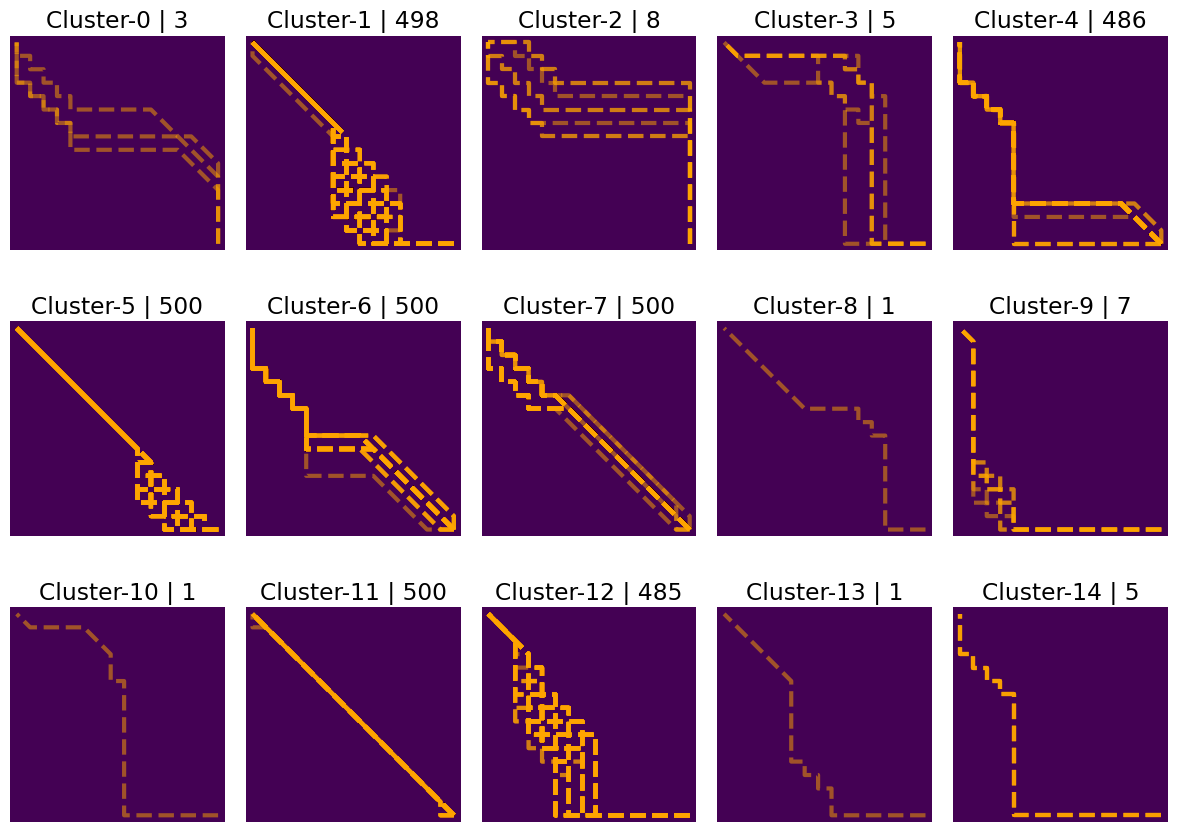

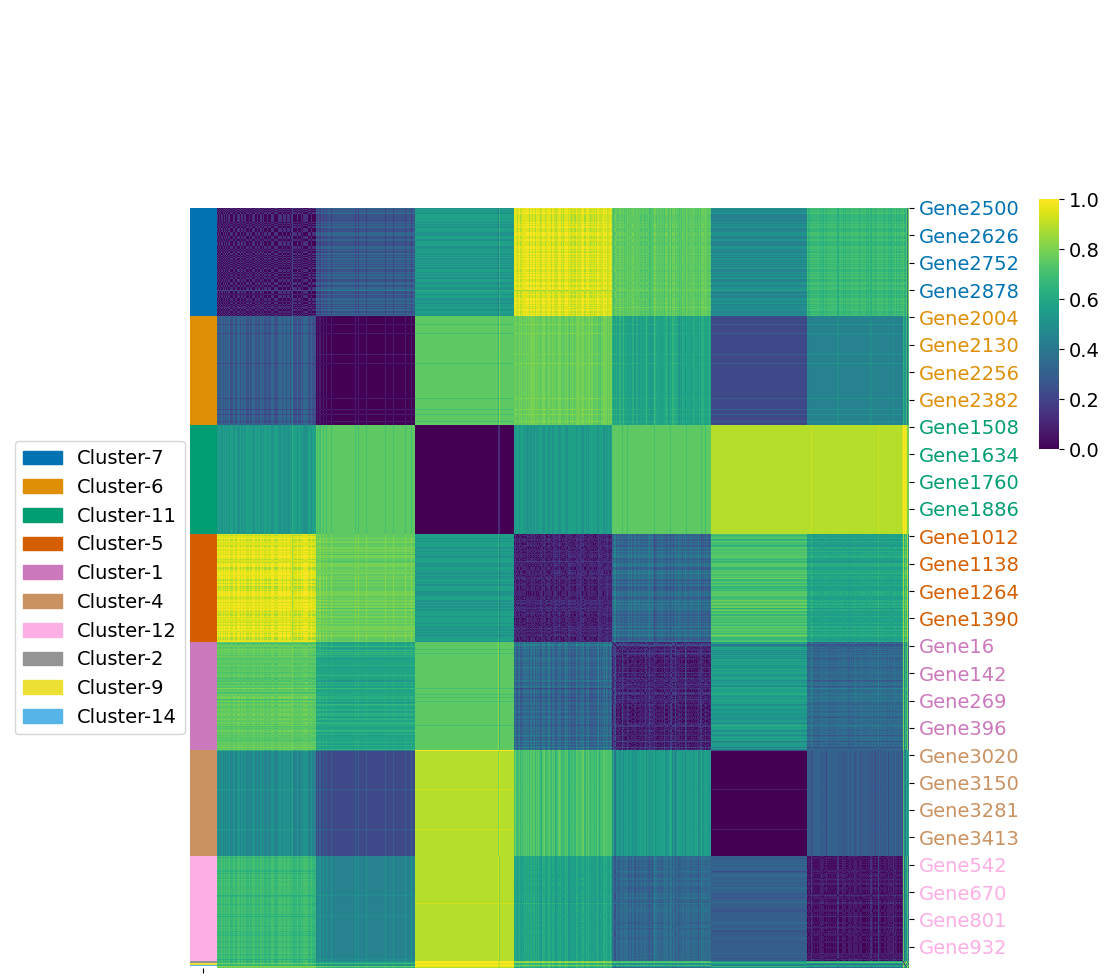

In [47]:
ClusterUtils.run_clustering(aligner_all, metric='levenshtein', DIST_THRESHOLD=0.22) 
ClusterUtils.visualise_clusters(aligner_all)
#plt.savefig('plots/ExtendedFigsATOREF/clusters_low_res.png')
VisualUtils.plot_distmap_with_clusters(aligner_all)
#plt.savefig('MS_FIGS/SimulationExperiments/simulated_data_clustermap_G2G.png', bbox_inches='tight')

In [62]:
ClusterUtils.print_cluster_average_alignments(aligner_all)



cluster:  0 IIIDIDIDIDIIIDDDDDDDMMMMVV 3
cluster:  1 MMMMMMIIIIIDIDIDIIDDDDDD 498
cluster:  2 IIIDIDIDIDIIIIIDDDDDDDDMMMV 8
cluster:  3 MDWWWWWWWIDIDIIIIIIIIIIIIDDDD 5
cluster:  4 IIIDIDIDIDIIIIIIDDDDDDDDMMM 486
cluster:  5 MMMMMMMMMIIIIDIDIDDDD 500
cluster:  6 IIIDIDIDIDIIIDDDDDMMMMMM 500
cluster:  7 IIIDIDIDIDDDMMMMMMMMM 500
cluster:  8 MMDMMMMWWWIDIDIIIIIIIDDD 1
cluster:  9 MIVVVVVVVVIDIDIDIIDDDDDDDDDDD 7
cluster:  10 MDDDWMMIIDIIIIIIIIIIDDDDDDD 1
cluster:  11 MMMMMMMMMMMMMMM 500
cluster:  12 MMMIIIIIDIDIDIIIIIDDDDDDDDD 485
cluster:  13 MMIMMMVVVVVDIDIDIIDDDDDDD 1
cluster:  14 IIIDIDIDIDIIIIIIDDDDDDDMMMW 5


In [48]:
def compute_misclustering_rate():
    misclustered_count = 0
    cid = 0
    for i in range(len(aligner_all.gene_clusters.keys())):
        cluster = aligner_all.gene_clusters[i]
        cluster_pattern =[]
        for g in cluster:
            cluster_pattern.append(pattern_map[g])

        pattern_types = np.unique(cluster_pattern, return_counts=True)[0]
        pattern_counts = np.unique(cluster_pattern, return_counts=True)[1]

        if(len(pattern_types)>1):
            max_count = np.max(pattern_counts)
            # recording the number of outliers in a cl
            for c in pattern_counts:
                if(c!=max_count):
                    misclustered_count += c
        print(cid, pattern_types, pattern_counts)#, ' || misclustered count = ',misclustered_count)
        cid+=1
    print('misclustered rate: ', misclustered_count*100/len(aligner_all.results),'%')
    
pattern_map = {}
for i in range(len(pattern_labels)):
    pattern_map[aligner_all.results[i].gene] = pattern_labels[i]
compute_misclustering_rate()

0 ['Convergence_05' 'Convergence_075'] [1 2]
1 ['Divergence_05'] [498]
2 ['Convergence_075'] [8]
3 ['Divergence_025'] [5]
4 ['Convergence_075' 'Divergence_025'] [484   2]
5 ['Divergence_075'] [500]
6 ['Convergence_05' 'Convergence_075'] [499   1]
7 ['Convergence_025'] [500]
8 ['Divergence_05'] [1]
9 ['Divergence_025'] [7]
10 ['Divergence_025'] [1]
11 ['AllMatch'] [500]
12 ['Divergence_025'] [485]
13 ['Divergence_05'] [1]
14 ['Convergence_075'] [5]
misclustered rate:  0.11428571428571428 %


In [79]:
g2g_alignment_strings = []
for g in aligner_all.gene_list:
    g2g_alignment_strings.append(aligner_all.results_map[g].alignment_str)

In [ ]:
E_g2g, df_g2g = SimExperimenter.compute_cluster_diagnostics(g2g_alignment_strings, gene_names=aligner_all.gene_list) 

Text(0, 0.5, 'Mis-clustering rate')

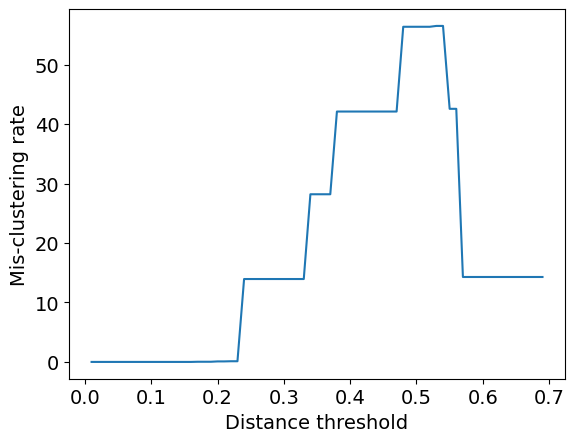

In [82]:
sb.lineplot(x=df_g2g['Distance threshold'] ,y= df_g2g['misclustering_rate'])
plt.xlabel('Distance threshold')
plt.ylabel('Mis-clustering rate')

In [35]:
#aligner_all.show_ordered_alignments() 

In [85]:
print(min(df_g2g.misclustering_rate)) 
print(max(df_g2g.misclustering_rate)) 

0.0
56.51428571428571


In [103]:
print(round(min(df_cellalign.misclustering_rate),2),',',round(max(df_cellalign.misclustering_rate),2) ) 

0.6 , 76.71


In [104]:
print(round(min(df_TrAGEDy_nullcut.misclustering_rate),2),',',round(max(df_TrAGEDy_nullcut.misclustering_rate),2) ) 

19.26 , 71.43


In [105]:
print(round(min(df_TrAGEDy_mincut.misclustering_rate),2),',',round(max(df_TrAGEDy_mincut.misclustering_rate),2) ) 

0.43 , 64.81


In [ ]:
# cellalign 3-state strings
ca_df = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/cellalign_3state_strings.csv')
cellalign_dtw_alignment_strings = [a.replace(' ','')  for a in ca_df['alignment_string']] 
E_cellalign , df_cellalign = SimExperimenter.compute_cluster_diagnostics(cellalign_dtw_alignment_strings, gene_names=list(ca_df.Gene) ) 

compute distance matrix
using hamming distance metric


  0%|          | 0/99 [00:00<?, ?it/s]


computing misclustering rates for different distance thresholds


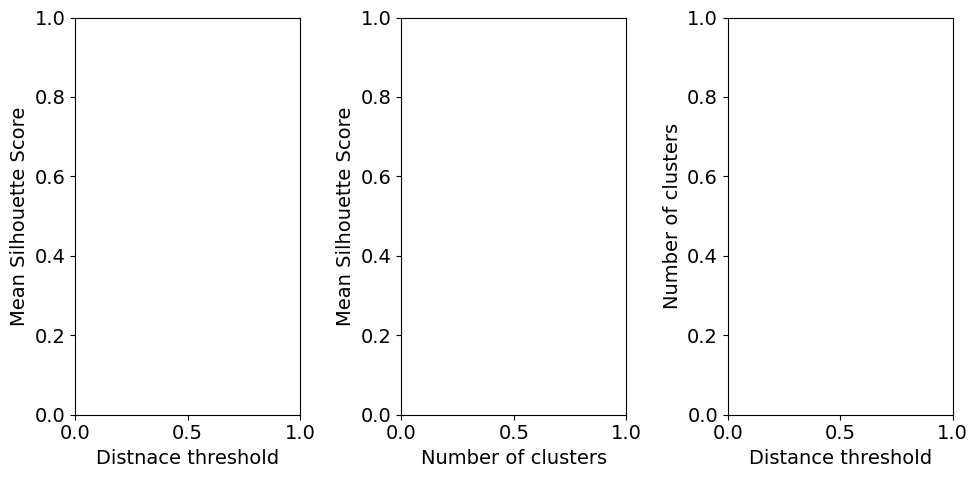

In [22]:
# cellalign 3-state strings
ca_df = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/cellalign_3state_strings.csv')
cellalign_dtw_alignment_strings = [a.replace(' ','')  for a in ca_df['alignment_string']] 
E_cellalign , df_cellalign = SimExperimenter.compute_cluster_diagnostics(cellalign_dtw_alignment_strings, gene_names=list(ca_df.Gene), distance_metric='hamming' ) 

In [26]:
np.max(E_cellalign)

0.0

In [ ]:
# hamming does not work for all match cases! 

compute distance matrix
using hamming distance metric


 58%|█████▊    | 57/99 [00:22<00:16,  2.55it/s]


computing misclustering rates for different distance thresholds
run agglomerative clustering |  0.01
silhouette_score:  0.9768571428571429
misclustered rate:  27.65714285714286 %
run agglomerative clustering |  0.02
silhouette_score:  0.9768571428571429
misclustered rate:  27.65714285714286 %
run agglomerative clustering |  0.03
silhouette_score:  0.9768571428571429
misclustered rate:  27.65714285714286 %
run agglomerative clustering |  0.04
silhouette_score:  0.9708309935357252
misclustered rate:  27.8 %
run agglomerative clustering |  0.05
silhouette_score:  0.9697605591989072
misclustered rate:  27.942857142857143 %
run agglomerative clustering |  0.06
silhouette_score:  0.9595716547068405
misclustered rate:  28.714285714285715 %
run agglomerative clustering |  0.07
silhouette_score:  0.8061296599452562
misclustered rate:  28.82857142857143 %
run agglomerative clustering |  0.08
silhouette_score:  0.8061296599452562
misclustered rate:  28.82857142857143 %
run agglomerative clusterin

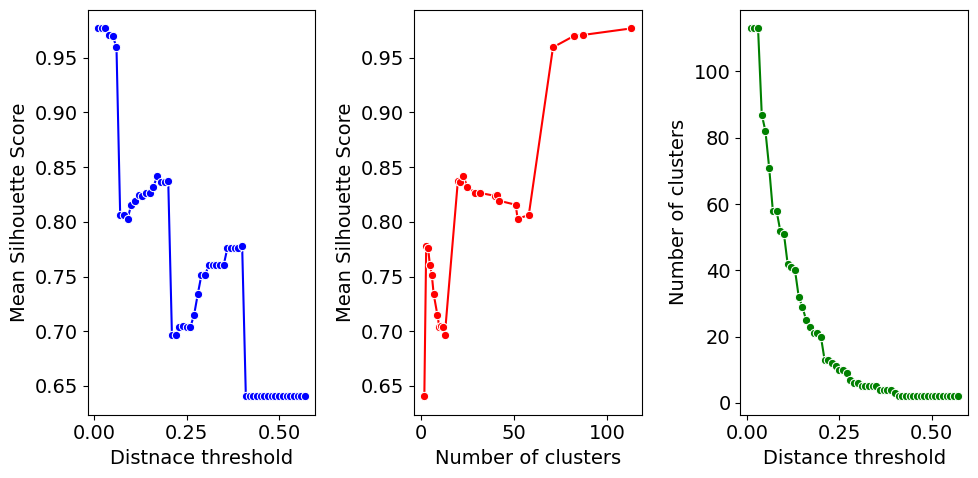

In [27]:
tr_df = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/TrAGEDy_5state_strings_nullcuttype.csv')
TrAGEDy_dtw_alignment_strings = [a.replace(' ','')  for a in tr_df['alignment_string']] 
E_TrAGEDy_nullcut, df_TrAGEDy_nullcut = SimExperimenter.compute_cluster_diagnostics(TrAGEDy_dtw_alignment_strings, gene_names=list(tr_df.Gene), distance_metric='hamming' ) 

In [28]:
print(round(min(df_TrAGEDy_nullcut.misclustering_rate),2),',',round(max(df_TrAGEDy_nullcut.misclustering_rate),2) ) 



27.66 , 71.43


compute distance matrix
using hamming distance metric


 61%|██████    | 60/99 [00:16<00:10,  3.73it/s]


computing misclustering rates for different distance thresholds
run agglomerative clustering |  0.01
silhouette_score:  0.9140173410404624
misclustered rate:  3.179190751445087 %
run agglomerative clustering |  0.02
silhouette_score:  0.9140173410404624
misclustered rate:  3.179190751445087 %
run agglomerative clustering |  0.03
silhouette_score:  0.9140173410404624
misclustered rate:  3.179190751445087 %
run agglomerative clustering |  0.04
silhouette_score:  0.6633300107429059
misclustered rate:  3.7933526011560694 %
run agglomerative clustering |  0.05
silhouette_score:  0.6022274014815105
misclustered rate:  4.44364161849711 %
run agglomerative clustering |  0.06
silhouette_score:  0.5318093048364115
misclustered rate:  4.913294797687861 %
run agglomerative clustering |  0.07
silhouette_score:  0.5058830639718872
misclustered rate:  5.238439306358382 %
run agglomerative clustering |  0.08
silhouette_score:  0.493109448358105
misclustered rate:  5.3106936416184976 %
run agglomerativ

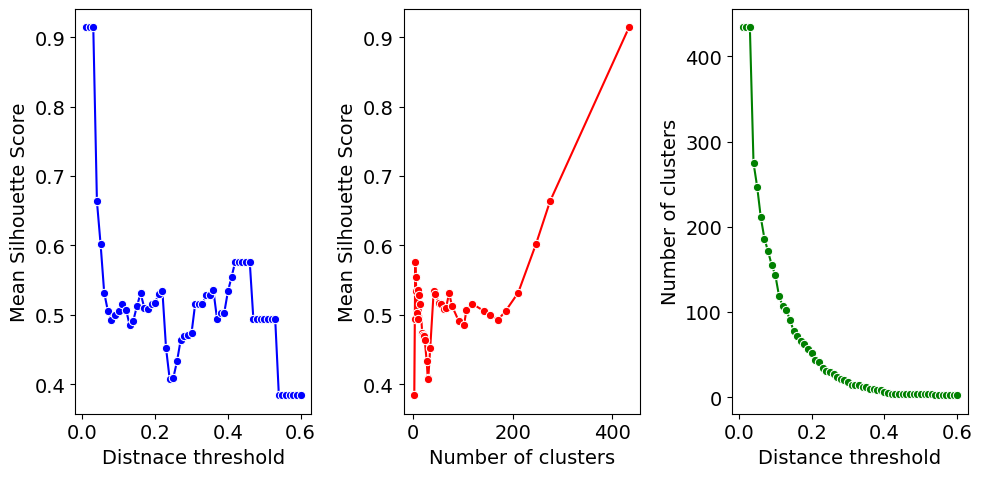

In [30]:

tr_df_mincut = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/TrAGEDy_5state_strings_minimumcut.csv')
TrAGEDy_dtw_alignment_strings_mincut = [a.replace(' ','')  for a in tr_df_mincut['alignment_string']] 
E_TrAGEDy_mincut, df_TrAGEDy_mincut = SimExperimenter.compute_cluster_diagnostics(TrAGEDy_dtw_alignment_strings_mincut , gene_names=list(tr_df_mincut.Gene) , distance_metric='hamming') 
print(round(min(df_TrAGEDy_mincut.misclustering_rate),2),',',round(max(df_TrAGEDy_mincut.misclustering_rate),2) ) 

In [ ]:
tr_df = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/TrAGEDy_5state_strings_nullcuttype.csv')
TrAGEDy_dtw_alignment_strings = [a.replace(' ','')  for a in tr_df['alignment_string']] 
E_TrAGEDy_nullcut, df_TrAGEDy_nullcut = SimExperimenter.compute_cluster_diagnostics(TrAGEDy_dtw_alignment_strings, gene_names=list(tr_df.Gene) ) 

In [ ]:
tr_df_mincut = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/TrAGEDy_5state_strings_minimumcut.csv')
TrAGEDy_dtw_alignment_strings_mincut = [a.replace(' ','')  for a in tr_df_mincut['alignment_string']] 
E_TrAGEDy_mincut, df_TrAGEDy_mincut = SimExperimenter.compute_cluster_diagnostics(TrAGEDy_dtw_alignment_strings_mincut , gene_names=list(tr_df_mincut.Gene) ) 

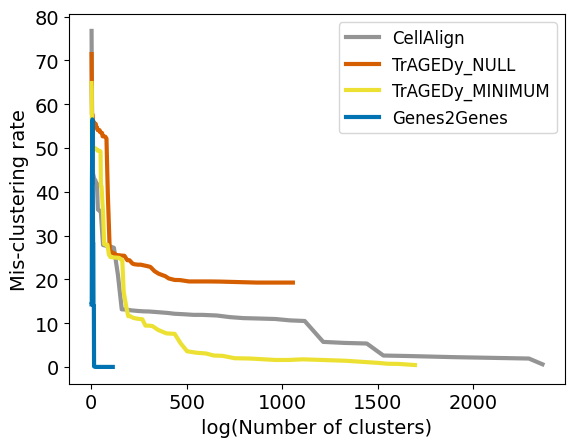

In [120]:
x = sb.color_palette('colorblind')
custom_palette = sb.color_palette([x[0], x[8], x[3]])

sb.lineplot(x=df_cellalign['Number of clusters'] ,y= df_cellalign['misclustering_rate'], label = 'CellAlign', color=x[7], linewidth=3)
sb.lineplot(x=df_TrAGEDy_nullcut['Number of clusters'] ,y= df_TrAGEDy_nullcut['misclustering_rate'], label = 'TrAGEDy_NULL',color= x[3], linewidth=3)
sb.lineplot(x=df_TrAGEDy_mincut['Number of clusters'] ,y= df_TrAGEDy_mincut['misclustering_rate'], label = 'TrAGEDy_MINIMUM', color= x[8], linewidth=3)
sb.lineplot(x=df_g2g['Number of clusters'] ,y= df_g2g['misclustering_rate'], label = 'Genes2Genes', color=x[0], linewidth=3)
plt.xlabel('log(Number of clusters)')
plt.ylabel('Mis-clustering rate')
plt.legend(fontsize=12)
plt.savefig('MS_FIGS/SimulationExperiments/ClusterDiagnostics/ClusteringComparison.png')
# annotate n optimal clusters

In [119]:
#sb.lineplot(x=df_cellalign['Distance threshold'] ,y= df_cellalign['misclustering_rate'], label = 'CellAlign')
#sb.lineplot(x=df_TrAGEDy_nullcut['Distance threshold'] ,y= df_TrAGEDy_nullcut['misclustering_rate'], label = 'TrAGEDy')
#sb.lineplot(x=df_TrAGEDy_mincut['Distance threshold'] ,y= df_TrAGEDy_mincut['misclustering_rate'], label = 'TrAGEDy minimum cut')
#sb.lineplot(x=df_g2g['Distance threshold'] ,y= df_g2g['misclustering_rate'], label = 'Genes2Genes')
#plt.xlabel('Distance threshold')
#plt.ylabel('Mis-clustering rate')
#plt.legend(fontsize=12)

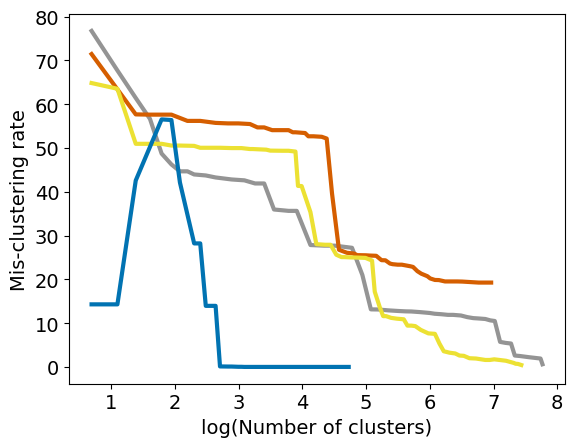

In [122]:
x = sb.color_palette('colorblind')
custom_palette = sb.color_palette([x[0], x[8], x[3]])

sb.lineplot(x=np.log(df_cellalign['Number of clusters']) ,y= df_cellalign['misclustering_rate'], label = 'CellAlign', color=x[7], linewidth=3, legend=False)
sb.lineplot(x=np.log(df_TrAGEDy_nullcut['Number of clusters']) ,y= df_TrAGEDy_nullcut['misclustering_rate'], label = 'TrAGEDy_NULL',color= x[3], linewidth=3,legend=False)
sb.lineplot(x=np.log(df_TrAGEDy_mincut['Number of clusters']) ,y= df_TrAGEDy_mincut['misclustering_rate'], label = 'TrAGEDy_MINIMUM', color= x[8], linewidth=3,legend=False)
sb.lineplot(x=np.log(df_g2g['Number of clusters']) ,y= df_g2g['misclustering_rate'], label = 'Genes2Genes', color=x[0], linewidth=3,legend=False)
plt.xlabel('log(Number of clusters)')
plt.ylabel('Mis-clustering rate')
#plt.legend(fontsize=12)
plt.savefig('MS_FIGS/SimulationExperiments/ClusterDiagnostics/ClusteringComparison.png')
# annotate n optimal clusters

In [18]:
#df_g2g.sort_values('Number of clusters')[0:60]

In [44]:
ClusterUtils.run_clustering(aligner_all, metric='levenshtein', DIST_THRESHOLD=0.16) 

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.16
silhouette_score:  0.795782014132674


In [45]:
ClusterUtils.print_cluster_average_alignments(aligner_all)

cluster:  0 MMMMMMMMMIIIIDIDIDDDD 500
cluster:  1 MIVVVVVVVVIDIDIDIIDDDDDDDDDDD 7
cluster:  2 MMMIIIIIDIDIDIIIIIDDDDDDDDD 485
cluster:  3 IIIDIDIDIDDDMMMMMMMMM 500
cluster:  4 IIIDIDIDIDIIIIIDDDDDDDDMMMV 5
cluster:  5 MMMMMMMMMMMMMMM 500
cluster:  6 IIIDIDIDIDIIIDDDDDDDMMMMVV 2
cluster:  7 MMMMMMIIIIIDIDIDIIDDDDDD 485
cluster:  8 MMMMMMIDIDIDIIIIIIDDDDDD 13
cluster:  9 IIIDIDIDIDIIIIIIDDDDDDDDMMM 482
cluster:  10 IIIDIDIDIDIIIIIDDDDDDMMMMW 1
cluster:  11 IIIDIDIDIDIIIDDDDDMMMMMM 499
cluster:  12 MDWWWWWWWIDIDIIIIIIIIIIIIDDDD 3
cluster:  13 MMIMMMVVVVVDIDIDIIDDDDDDD 1
cluster:  14 IIIDIDIDIDIIIIIIDDDDDDDMMMW 5
cluster:  15 IIIDIDIDIDIDDDDDMMMMMMVV 1
cluster:  16 IIIDIDIDIDIDDDDDDDDDMMVVVVVV 3
cluster:  17 MMDMMMMWWWIDIDIIIIIIIDDD 1
cluster:  18 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 4
cluster:  19 MMDWMWWWIDIDIDIIIIIIIIIDDDD 1
cluster:  20 MDWMWWWIDIDIIIIIIIIIIIDDDDDD 1
cluster:  21 MDDDWMMIIDIIIIIIIIIIDDDDDDD 1


compute distance matrix
using hamming distance metric


 69%|██████▊   | 68/99 [00:34<00:15,  1.98it/s]


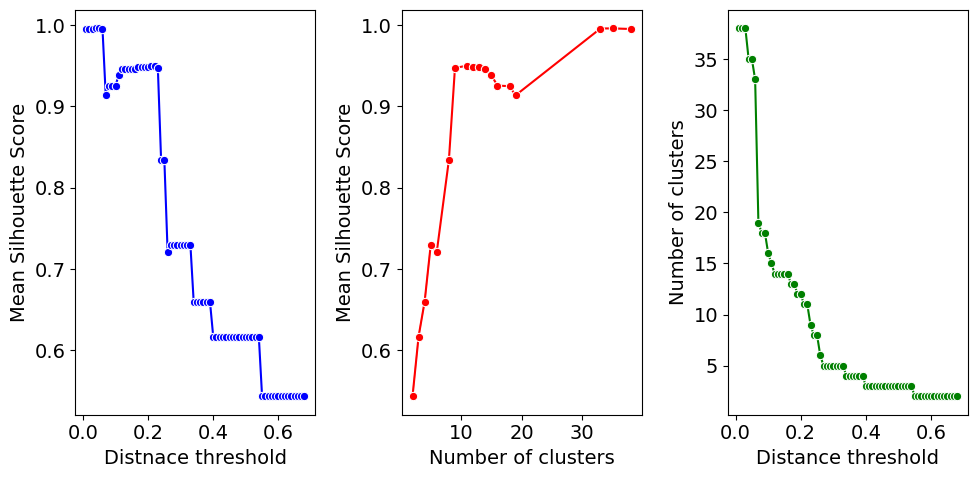

In [43]:
df = ClusterUtils.run_clustering(aligner_all, metric='hamming', experiment_mode=True) 
#plt.savefig('plots/Fig3/hamming_dist_cluster_diagnostics_plot.png')

In [52]:
#pickle.dump(aligner_all, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/aligner_simulated_data_all.pkl', 'wb')) 

In [76]:
d = ClusterUtils.run_clustering_for_subset(aligner_all,metric='hamming', MIN_DIST=0.00000001) 
np.mean(d['n_unique_strings'] - d['n_identified_clusters'])

18.02

In [101]:
ClusterUtils.run_clustering(aligner_all, metric='hamming', experiment_mode=False, DIST_THRESHOLD=0.00000001) 

compute distance matrix
using hamming distance metric
run agglomerative clustering |  0.0
silhouette_score:  0.9951428571428571


In [102]:
len(aligner_all.gene_clusters.keys())

38

# CellAlign k-mean clustering results

60.4
42.57142857142857


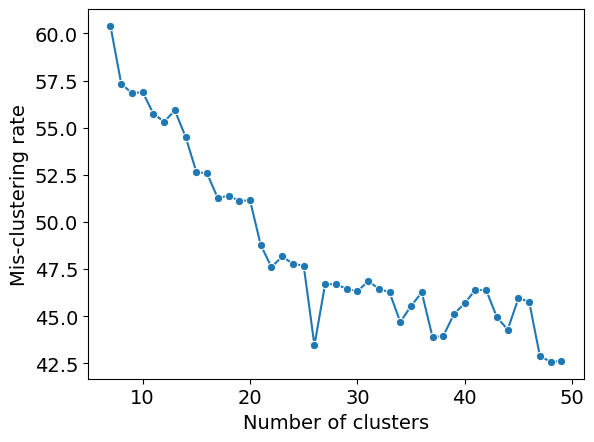

In [74]:
# checking cellalign cluster results
adata_ref_ca = anndata.read_h5ad('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/R.h5ad')
adata_query_ca = anndata.read_h5ad('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/Q.h5ad')

def compute_misclustering_rate(CA_gene_clusters):
    misclustered_count = 0
    cid = 0
    for i in range(len(CA_gene_clusters)):
        cluster = CA_gene_clusters[i]
        cluster_pattern =[]
        for g in cluster:
            cluster_pattern.append(pattern_map[g])

        pattern_types = np.unique(cluster_pattern, return_counts=True)[0]
        pattern_counts = np.unique(cluster_pattern, return_counts=True)[1]

        if(len(pattern_types)>1):
            max_count = np.max(pattern_counts)
            # recording the number of outliers in a cl
            for c in pattern_counts:
                if(c!=max_count):
                    misclustered_count += c
        #print(cid, pattern_types, pattern_counts)#, ' || misclustered count = ',misclustered_count)
        cid+=1
    #print('misclustered rate: ', misclustered_count*100/len(aligner_all.results),'%')
    return misclustered_count*100/len(aligner_all.results)
    
    
def get_CA_gene_cluster(cluster_test_id):
    
    CA_gene_clusters = {}
    for g in adata_ref_ca.var_names:

        cid = adata_ref_ca.var[cluster_test_id][g]
        if(cid-1 not in CA_gene_clusters.keys()):
            CA_gene_clusters[cid-1] = []
        CA_gene_clusters[cid-1].append(g)
    return CA_gene_clusters
    
misclustering_rates = [] 
for i in range(7,50):
    #print(i)
    CA_gene_clusters= get_CA_gene_cluster('clusters '+str(i))
    misclustering_rates.append(compute_misclustering_rate(CA_gene_clusters))
    
sb.lineplot(x=np.arange(7,50), y= misclustering_rates, marker="o") 
plt.xlabel('Number of clusters')
plt.ylabel('Mis-clustering rate')
print(np.max(misclustering_rates) )
print(np.min(misclustering_rates) ) 

60.4
42.57142857142857


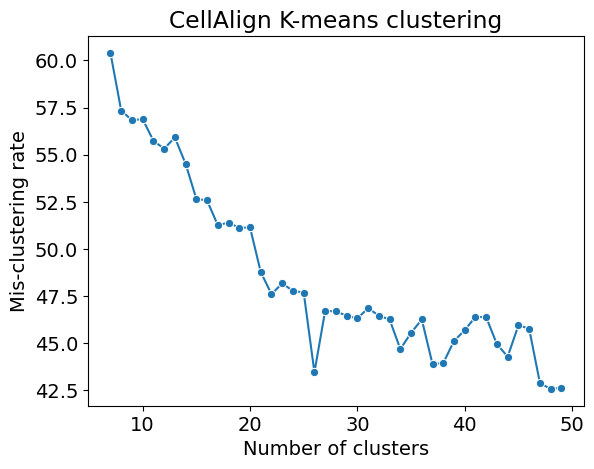

In [77]:
sb.lineplot(x=np.arange(7,50), y= misclustering_rates, marker="o") 
plt.xlabel('Number of clusters')
plt.ylabel('Mis-clustering rate')
print(np.max(misclustering_rates) )
print(np.min(misclustering_rates) ) 
plt.title('CellAlign K-means clustering')
plt.savefig('MS_FIGS/SimulationExperiments/ClusterDiagnostics/CellAlign_Kmeans.png')

In [69]:
ca_df = pd.read_csv('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/Experiment1/cellalign_3state_strings.csv')
dtw_alignments = [a.replace(' ','')  for a in ca_df['alignment_string']] 

In [78]:
len(np.unique(dtw_alignments) )

2363

In [193]:
def run_clustering(alignment_strings, aligner, metric,DIST_THRESHOLD=0.2, experiment_mode=False):

    # compute distance matrix 
    print('compute distance matrix')
    dist_mat_functions = {'hamming': ClusterUtils.compute_hamming_dist_matrix, 'levenshtein': ClusterUtils.compute_levenshtein_dist_matrix}
    compute_dist_matrix = dist_mat_functions[metric]
    E = compute_dist_matrix(alignment_strings)
    
    if(experiment_mode):
        scores = [];  n_clusters = []; dist_thresholds = np.arange(0.01,1.0,0.01); score_modes = []; n_small_clusters = [] 
        eval_dists = []
        for D_THRESH in tqdm(dist_thresholds): 
            gene_clusters, cluster_ids, silhouette_score, silhouette_score_mode, n_small_cluster = ClusterUtils.run_agglomerative_clustering(E, aligner.gene_list, D_THRESH)
            
            if(len(gene_clusters.keys())==1):
                break
            scores.append(silhouette_score)
            n_clusters.append(len(gene_clusters.keys()))
            score_modes.append(silhouette_score_mode)
            n_small_clusters.append(n_small_cluster)
            eval_dists.append(D_THRESH)
            
        plt.rcParams.update({'font.size': 14})
        plt.subplots(1,3,figsize=(10,5))
        plt.subplot(1,3,1)
        sb.lineplot(x=eval_dists, y=scores, color = 'blue', marker='o') 
        plt.xlabel('Distnace threshold')
        plt.ylabel('Mean Silhouette Score')
        plt.subplot(1,3,2)
        sb.lineplot(x=n_clusters, y=scores, color='red', marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Mean Silhouette Score')
        plt.subplot(1,3,3)
        sb.lineplot(x=eval_dists, y=n_clusters, color='green', marker='o')
        plt.xlabel('Distance threshold')
        plt.ylabel('Number of clusters')
        plt.tight_layout() 
        df = pd.DataFrame([eval_dists,scores,n_clusters]).transpose()
        df.columns = ['Distance threshold', 'Mean Silhouette Score','Number of clusters']
        return df

    else:
        print('run agglomerative clustering | ', np.round(DIST_THRESHOLD,2) )
        gene_clusters, cluster_ids, silhouette_score, silhouette_score_samples, n_small_cluster  = ClusterUtils.run_agglomerative_clustering(E, aligner.gene_list, DIST_THRESHOLD)
        print('silhouette_score: ', silhouette_score)
        return gene_clusters 

        #return aligner


compute distance matrix
using levenshtein distance metric


 66%|██████▌   | 65/99 [02:11<01:08,  2.02s/it]


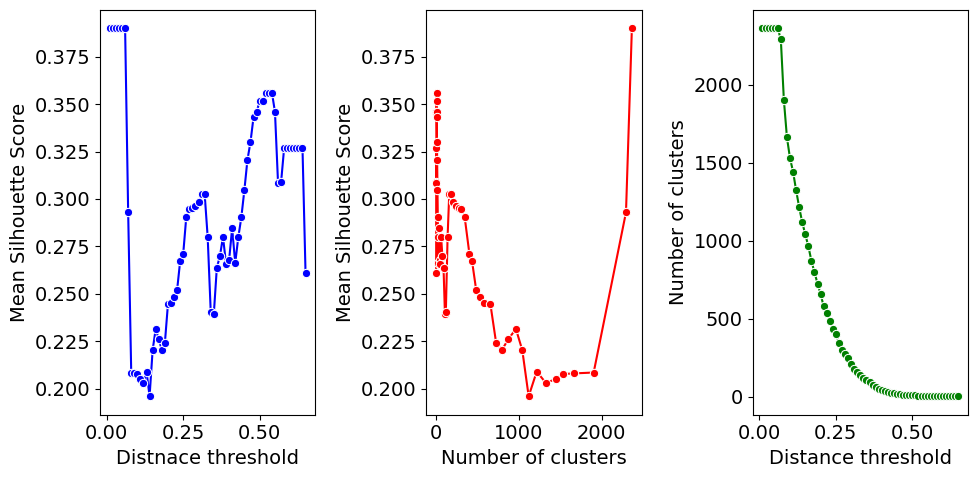

In [186]:
df = run_clustering(dtw_alignments, aligner_all, metric='levenshtein', experiment_mode=True) 

In [189]:
df.sort_values('Number of clusters')[0:20]

Distance threshold  Mean Silhouette Score  Number of clusters
64                0.65               0.260802                 2.0
57                0.58               0.326862                 3.0
58                0.59               0.326862                 3.0
59                0.60               0.326862                 3.0
63                0.64               0.326862                 3.0
61                0.62               0.326862                 3.0
62                0.63               0.326862                 3.0
60                0.61               0.326862                 3.0
56                0.57               0.308870                 4.0
55                0.56               0.308651                 5.0
54                0.55               0.345979                 6.0
53                0.54               0.356164                 7.0
52                0.53               0.356164                 7.0
51                0.52               0.356164                 7.0
50                0.51               0.351639                 8.0
49                0.50               0.351639                 8.0
48                0.49               0.345805                 9.0
47                0.48               0.343219                10.0
46                0.47               0.330120                12.0
45                0.46               0.320595                14.0

In [ ]:
# optimal mean silhoutte score (2nd highest locally optimal)  0.54 	0.356164 	7.0

In [194]:
dtw_gene_clusters = run_clustering(dtw_alignments, aligner_all, metric='levenshtein',DIST_THRESHOLD=0.54, experiment_mode=False) 

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.54
silhouette_score:  0.3561637838289814


In [198]:
def compute_misclustering_rate(dtw_gene_clusters):
    misclustered_count = 0
    cid = 0
    for i in range(len(dtw_gene_clusters)):
        cluster = dtw_gene_clusters[i]
        cluster_pattern =[]
        for g in cluster:
            cluster_pattern.append(pattern_map[g])

        pattern_types = np.unique(cluster_pattern, return_counts=True)[0]
        pattern_counts = np.unique(cluster_pattern, return_counts=True)[1]

        if(len(pattern_types)>1):
            max_count = np.max(pattern_counts)
            # recording the number of outliers in a cl
            for c in pattern_counts:
                if(c!=max_count):
                    misclustered_count += c
        print(cid, pattern_types, pattern_counts)#, ' || misclustered count = ',misclustered_count)
        cid+=1
    print('misclustered rate: ', misclustered_count*100/len(aligner_all.results),'%')
    return misclustered_count*100/len(aligner_all.results)

compute_misclustering_rate(dtw_gene_clusters)

0 ['AllMatch' 'Convergence_025' 'Convergence_05'] [132 219   5]
1 ['AllMatch' 'Convergence_025' 'Divergence_05' 'Divergence_075'] [ 46   3   3 277]
2 ['AllMatch'] [254]
3 ['AllMatch' 'Divergence_05' 'Divergence_075'] [  9   4 220]
4 ['AllMatch' 'Convergence_025' 'Convergence_05' 'Divergence_075'] [ 38 274   5   1]
5 ['AllMatch' 'Convergence_05' 'Convergence_075' 'Divergence_025'
 'Divergence_05'] [  5 269 316 178 221]
6 ['AllMatch' 'Convergence_025' 'Convergence_05' 'Convergence_075'
 'Divergence_025' 'Divergence_05' 'Divergence_075'] [ 16   4 221 184 322 272   2]
misclustered rate:  46.22857142857143 %


46.22857142857143

In [199]:
len(np.unique(dtw_alignments)) 

2363

In [201]:
# CellAlign group wise cell-level high dimensional alignment

temp = pd.read_csv('SimulationData/cellalign_output_clusters/cellalign_3state_strings_group_wise.csv')
temp
celllevel_dtw_alignments = [a.replace(' ','')  for a in temp['alignment_string']]
i=0
for a in celllevel_dtw_alignments:
    print(temp['Gene'][i], VisualUtils.color_al_str(a))
    i+=1

Unnamed: 0               Gene  \
0           1  R_match - Q_match   
1           2  R_Div25 - Q_Div25   
2           3  R_Div05 - Q_Div05   
3           4  R_Div75 - Q_Div75   
4           5  R_Con25 - Q_Con25   
5           6  R_Con05 - Q_Con05   
6           7  R_Con75 - Q_Con75   

                                    alignment_string  
0                    M M M M M M M M M M M M M M V W  
1   M V W V V V V V V V V V V V V V W W W W W W W...  
2   M M M M M V W V V V V V V V V V W W W W W W W...  
3        M M M M M M M M V W V W V V V V V W W W W W  
4              M W W W W M V V V M V M M M M M M M M  
5      M W W W W W W W W M V V V V V V V V M M M M M  
6   M W W W W W W W W W W W W M V V V V V V V V V...

R_match - Q_match MMMMMMMMMMMMMMVW
R_Div25 - Q_Div25 MVWVVVVVVVVVVVVVWWWWWWWWWWWWW
R_Div05 - Q_Div05 MMMMMVWVVVVVVVVVWWWWWWWWW
R_Div75 - Q_Div75 MMMMMMMMVWVWVVVVVWWWWW
R_Con25 - Q_Con25 MWWWWMVVVMVMMMMMMMM
R_Con05 - Q_Con05 MWWWWWWWWMVVVVVVVVMMMMM
R_Con75 - Q_Con75 MWWWWWWWWWWWWMVVVVVVVVVVVVM


# Writing alignments to file

In [21]:
ClusterUtils.run_clustering(aligner_all, metric='levenshtein', DIST_THRESHOLD=0.22) 

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.22
silhouette_score:  0.8180643432942113


In [22]:
aligner = aligner_all
df = []
for g in aligner.gene_list:
    al_obj = aligner.results_map[g]
    df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0], al_obj.cluster_id ] )
df = pd.DataFrame(df)
df.columns = ['Gene','5-state alignment string','Alignment similarity %','Cluster_id']
df

Gene     5-state alignment string  Alignment similarity %  \
0        Gene0     MMMMMMIIIIIIDIDIDIDDDDDD                   25.00   
1        Gene1     MMMMMMIIIIDIDIDIIIDDDDDD                   25.00   
2        Gene2     MMMMMMIIIIIDIDIIIDDDDDDD                   25.00   
3        Gene3     MMMMMMIIIIIIIDIDIDDDDDDD                   25.00   
4        Gene4     MMMMMMIIIIIIIDIDIDDDDDDD                   25.00   
...        ...                          ...                     ...   
3495  Gene3495  IIIDIDIDIDIIIIIIDDDDDDDDMMM                   11.11   
3496  Gene3496  IIIDIDIDIDIIIIIIDDDDDDDDMMM                   11.11   
3497  Gene3497  IIIDIDIDIDIIIIIIDDDDDDDDMMM                   11.11   
3498  Gene3498  IIIDIDIDIDIIIIIIDDDDDDDDMMM                   11.11   
3499  Gene3499  IIIDIDIDIDIIIIIIDDDDDDDDMMM                   11.11   

      Cluster_id  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
3495           4  
3496           4  
3497           4  
3498           4  
3499           4  

[3500 rows x 4 columns]

In [25]:
df.to_csv('results/G2G_SimulationExperiment1_alignments.csv')

# Negative control dataset 

In [26]:
import torch
import gpytorch
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import regex as re
from tqdm import tqdm
import pickle
import anndata
import os,sys,inspect
import VisualUtils 
import anndata
import scipy.sparse
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 

# new source imports 
import Main 
import ClusterUtils
import TimeSeriesPreprocessor
import VisualUtils
import warnings
import pickle
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
anndata.__version__

'0.8.0'

In [27]:
adata_ref = anndata.read_h5ad('SimulationData/Datasets/adata_negative_control_1.h5ad')
adata_query = anndata.read_h5ad('SimulationData/Datasets/adata_negative_control_2.h5ad')

In [28]:
x = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_ref.obs['time'] = x
x = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))
adata_query.obs['time'] = x
print(min(adata_ref.obs['time']), max(adata_ref.obs['time']))
print(min(adata_query.obs['time']), max(adata_query.obs['time'])) 

0.0 1.0
0.0 1.0


In [30]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

16

In [31]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

15

# trying max n points for optimal binning = 15
Optimal equal number of bins for R and Q =  15


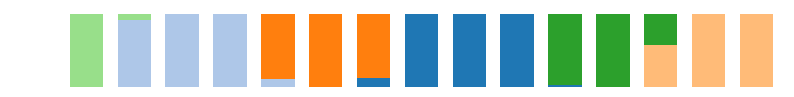

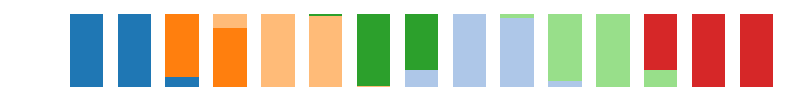

In [32]:
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=15, 
                                        ANNOTATION_COLNAME='seurat_clusters', optimal_binning=False, PLOT=False)

In [33]:
N_BINS = 15
STATE_PARAMS = [0.99, 0.1, 0.7]
aligner = Main.RefQueryAligner(adata_ref, adata_query, adata_ref.var_names, N_BINS)
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE=0.1
aligner.state_params = STATE_PARAMS  
aligner.optimal_binning = True
aligner.opt_binning_S = vs.optimal_bining_S
aligner.opt_binning_T = vs.optimal_bining_T

In [34]:
aligner.align_all_pairs() 

WINDOW_SIZE= 0.1


  0%|          | 0/619 [00:00<?, ?it/s]

Average Alignment:  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD


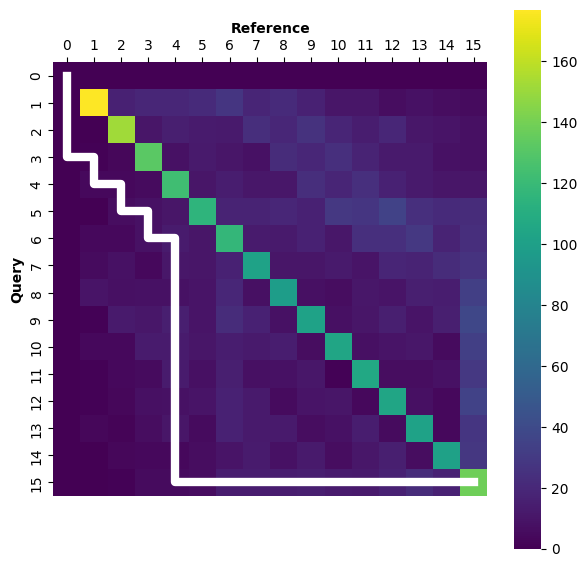

In [35]:
aligner.get_aggregate_alignment() 

HK118 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
HK110 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
HK45 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
HK283 MMMMMMMMMMMMMMM


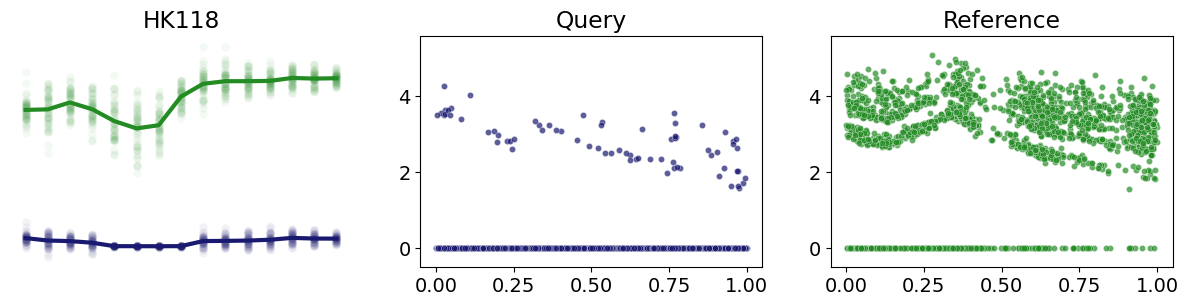

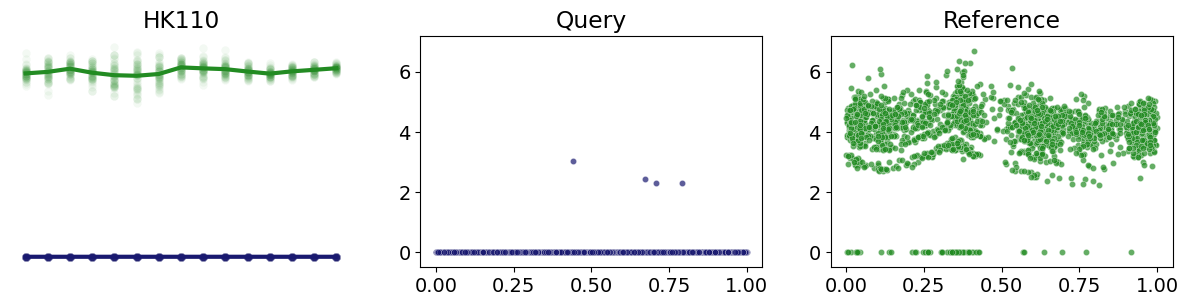

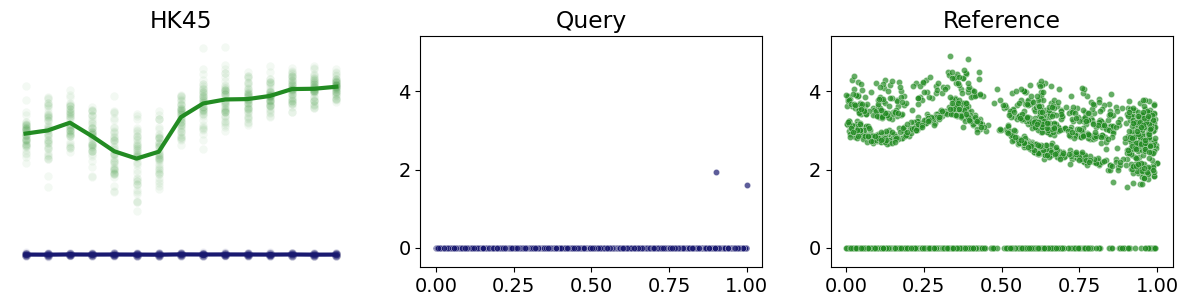

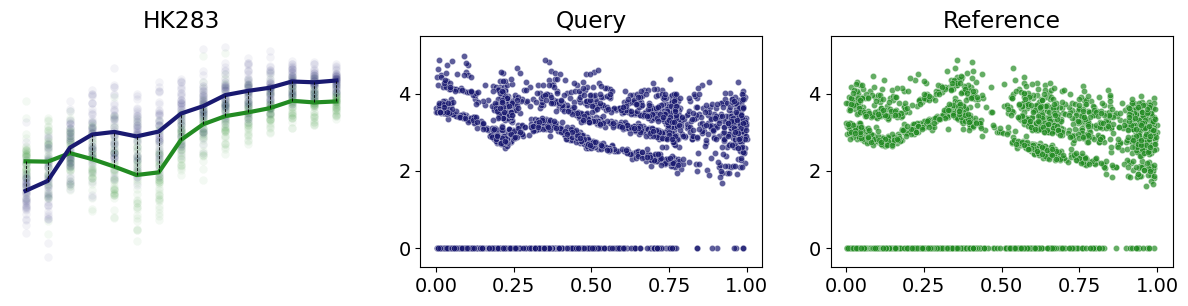

In [136]:
for g in ['HK118', 'HK110', 'HK45','HK283']:
    VisualUtils.plotTimeSeries(g, aligner)
    print(g, aligner.results_map[g].alignment_str)
    plt.savefig('MS_FIGS/SimulationExperiments/'+g+'_negative_control_gene_example.png')

## Extreme cases test

IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD


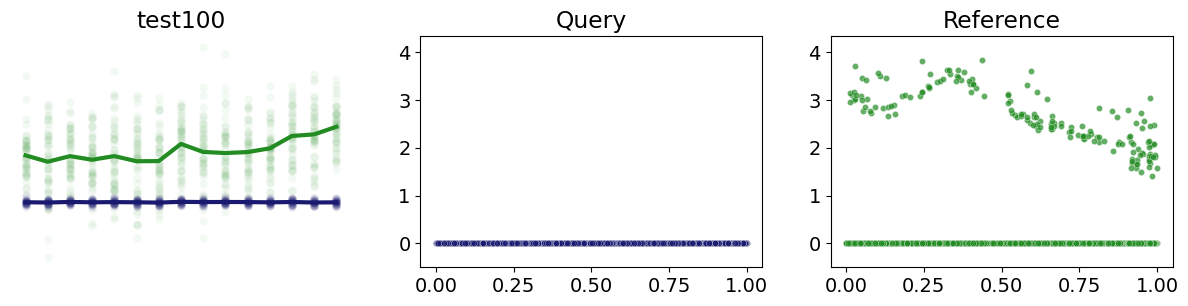

In [21]:
TEST_ID='test100'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK70']
aligner.query_mat[TEST_ID] = aligner.query_mat['HK70']
aligner.query_mat[TEST_ID][aligner.query_time<0.5] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD


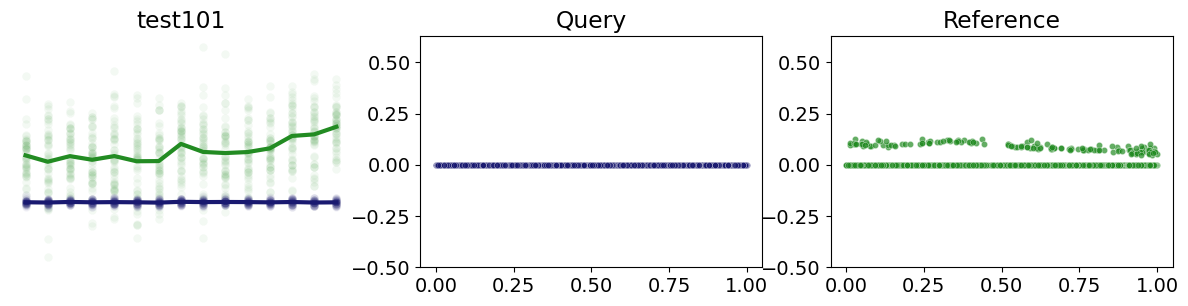

In [22]:
TEST_ID='test101'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK70']
aligner.query_mat[TEST_ID] = aligner.query_mat['HK70']
aligner.query_mat[TEST_ID][aligner.query_time<0.5] = 0.0
aligner.ref_mat[TEST_ID] = aligner.ref_mat[TEST_ID]/30

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

MMMMMMMMVVVVVVVDDDDDDD


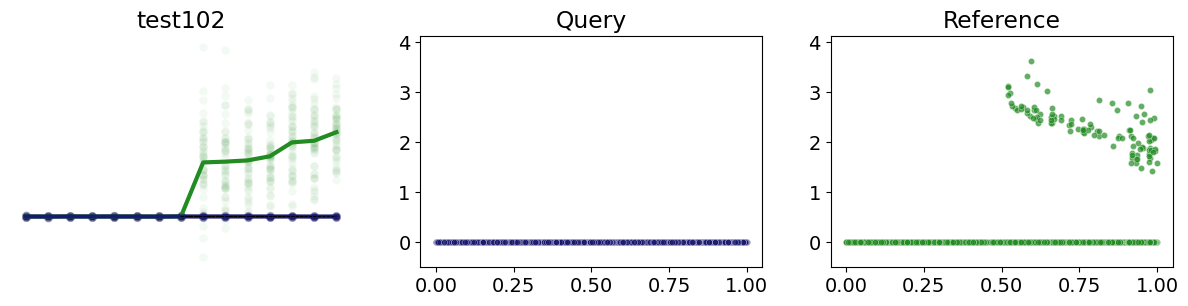

In [23]:
TEST_ID='test102'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK70']
aligner.query_mat[TEST_ID] = aligner.query_mat['HK70']
aligner.ref_mat[TEST_ID][aligner.ref_time<0.5] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

MMMMMMMMVVVVVVVDDDDDDD


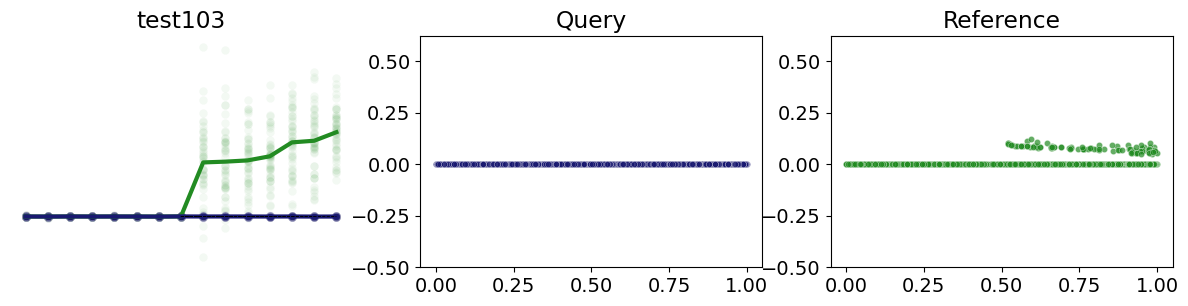

In [24]:
TEST_ID='test103'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK70']/30
aligner.query_mat[TEST_ID] = aligner.query_mat['HK70']
aligner.ref_mat[TEST_ID][aligner.ref_time<0.5] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

DDDDDDMMMMMMMMMVVVVVV


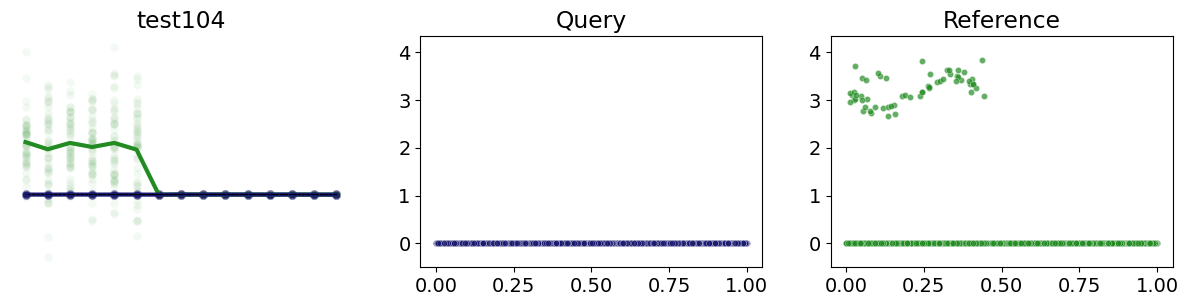

In [25]:
TEST_ID='test104'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK70']
aligner.query_mat[TEST_ID] = aligner.query_mat['HK70']
aligner.ref_mat[TEST_ID][aligner.ref_time>0.5] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

DDDDDDMMMMMMMMMVVVVVV


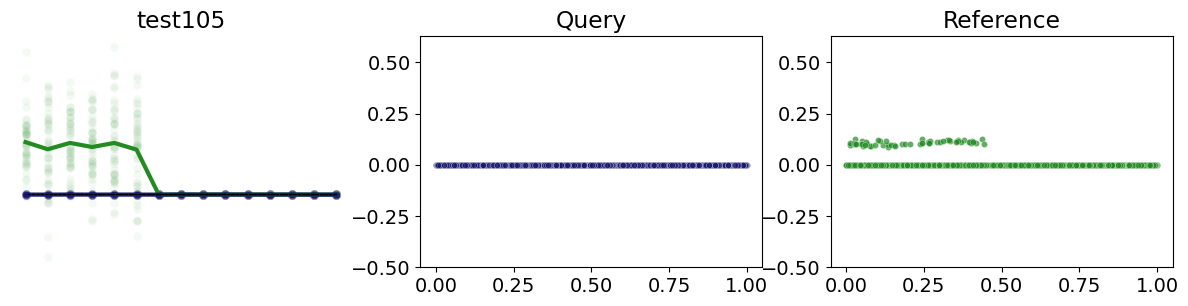

In [26]:
TEST_ID='test105'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK70']/30
aligner.query_mat[TEST_ID] = aligner.query_mat['HK70']
aligner.ref_mat[TEST_ID][aligner.ref_time>0.5] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)
plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

MMMMMMMMMMMMMMM


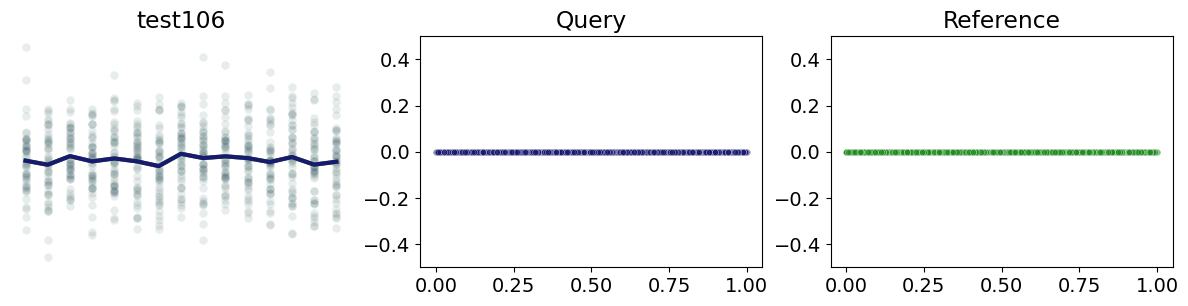

In [27]:
TEST_ID='test106'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK70']/30
aligner.query_mat[TEST_ID] = 0.0
aligner.ref_mat[TEST_ID] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

IIIIIIIIMMMMMMMWWWWWWWW


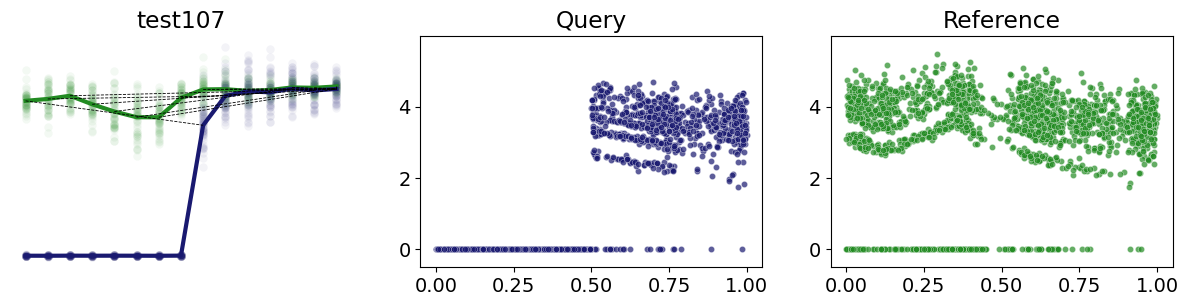

In [28]:
TEST_ID='test107'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK170']
aligner.query_mat[TEST_ID] = aligner.query_mat['Target20']
aligner.query_mat[TEST_ID][aligner.query_time<0.5] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

IIIIIIMMMWWWWWWWWWWWIIIIIID


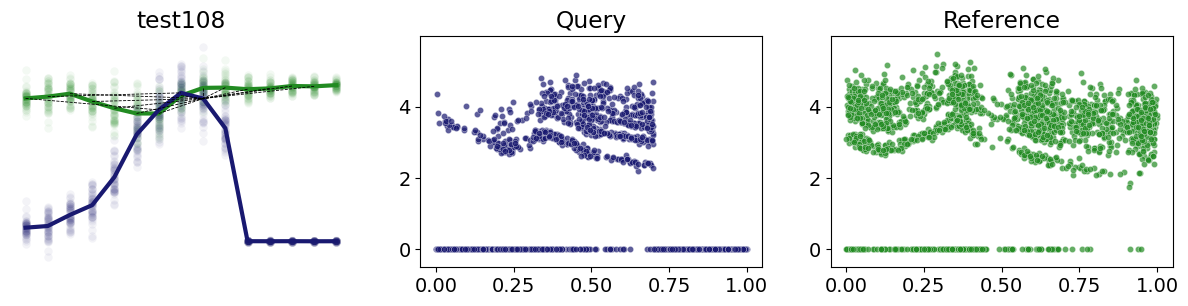

In [29]:
TEST_ID='test108'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK170']
aligner.query_mat[TEST_ID] = aligner.query_mat['Target20']
aligner.query_mat[TEST_ID][aligner.query_time>0.7] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

IIIIIIMMMMMMMMIDDDDDDD


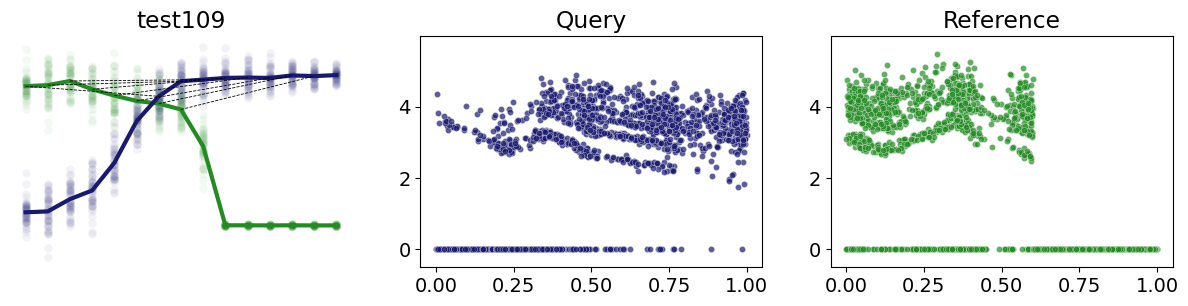

In [30]:
TEST_ID='test109'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK170']
aligner.query_mat[TEST_ID] = aligner.query_mat['Target20']
aligner.ref_mat[TEST_ID][aligner.ref_time>0.6] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

IIIDIDIDIDIIDDDDMMMMMMM


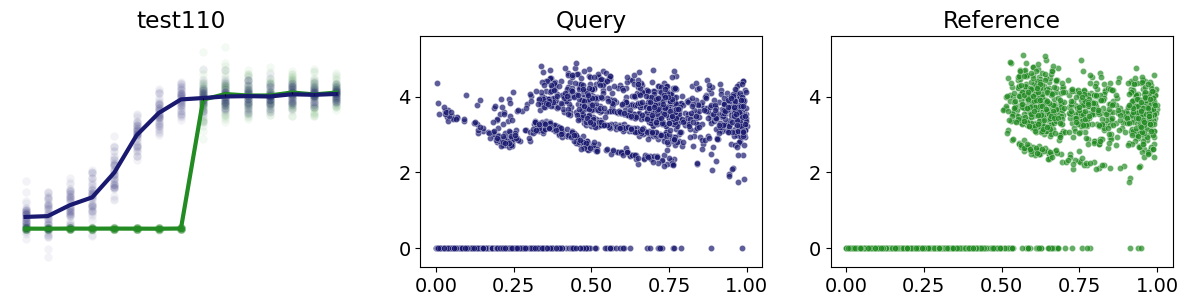

In [31]:
TEST_ID='test110'
aligner.ref_mat[TEST_ID] = aligner.ref_mat['HK170']
aligner.query_mat[TEST_ID] = aligner.query_mat['Target20']
aligner.ref_mat[TEST_ID][aligner.ref_time<0.5] = 0.0

a = aligner.align_single_pair(TEST_ID)
aligner.results_map[TEST_ID] = a
VisualUtils.plotTimeSeries(TEST_ID, aligner)
print(a.alignment_str)

plt.savefig('SimulationData/ExtremeCasePlots/plot_'+TEST_ID+'.png')

In [34]:
adata_r = anndata.AnnData(aligner.ref_mat[['test100','test101','test102','test103','test104','test105','test106','test107','test108','test109','test110']])
adata_q = anndata.AnnData(aligner.query_mat[['test100','test101','test102','test103','test104','test105','test106','test107','test108','test109','test110']])
adata_r.obs['time'] = aligner.ref_time
adata_q.obs['time'] = aligner.query_time
adata_r.obs['seurat_clusters']= adata_ref.obs['seurat_clusters']
adata_q.obs['seurat_clusters']= adata_query.obs['seurat_clusters']
#adata_r.write_h5ad('SimulationData/ExtremeCasePlots/adata_r.h5ad')
#adata_q.write_h5ad('SimulationData/ExtremeCasePlots/adata_q.h5ad')

# Writing alignments to file

In [36]:
len(aligner.gene_list)

619

In [37]:
df = []
for g in aligner.gene_list:
    al_obj = aligner.results_map[g]
    df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0]] )
df = pd.DataFrame(df)
df.columns = ['Gene','5-state alignment string','Alignment similarity %']
df

Gene        5-state alignment string  Alignment similarity %
0    Burn1-TF1      IIIIIDIDIDIMMMMIIIDDDDDDDD                   15.38
1    Burn2-TF1                 MMMMMMMMMMMMMMM                  100.00
2    Burn3-TF1                 MMMMMMMMMMMMMMM                  100.00
3    Burn4-TF1           MWWWWWDMMMMMMMMIIIIII                   66.67
4       A1-TF1                 MMMMMMMMMMMMMMM                  100.00
..         ...                             ...                     ...
614      HK296  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD                    0.00
615      HK297  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD                    0.00
616      HK298              MMMMDDDMMMMMMMMIII                   66.67
617      HK299                 MMMMMMMMMMMMMMM                  100.00
618      HK300  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD                    0.00

[619 rows x 3 columns]

In [38]:
df.to_csv('results/G2G_negative_control_alignments.csv')

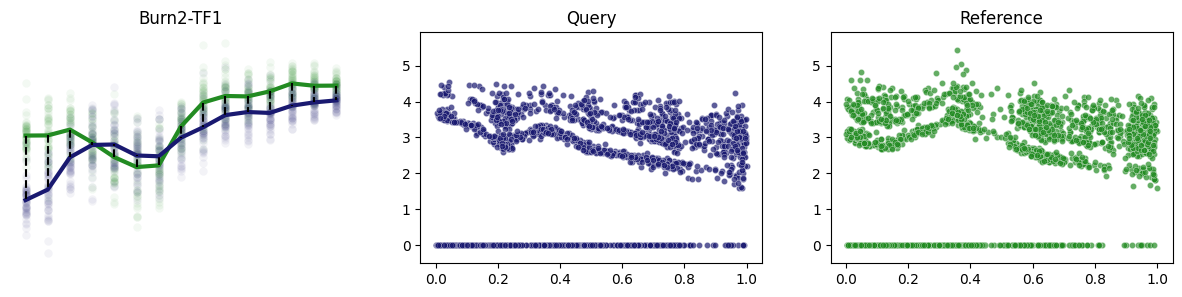

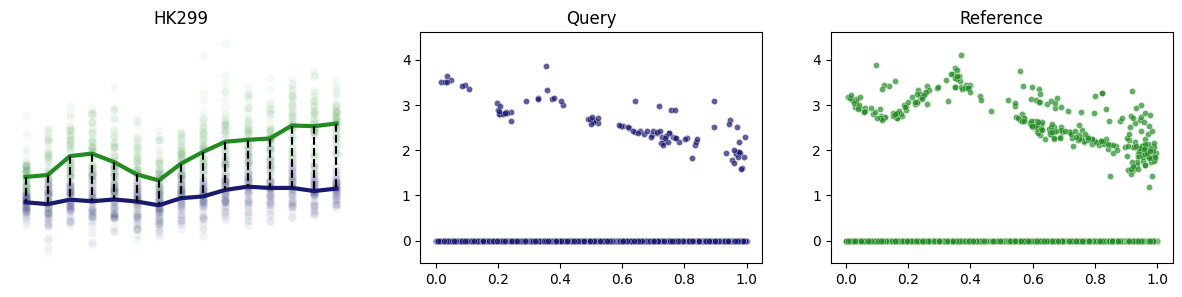

In [40]:
VisualUtils.plotTimeSeries('Burn2-TF1', aligner)
VisualUtils.plotTimeSeries('HK299', aligner)

# ATTIC

In [40]:
#import scanpy as sc
#adata_ref.obs['ID'] = np.repeat('Ref',adata_ref.shape[0])
#adata_query.obs['ID'] = np.repeat('Query',adata_query.shape[0])
#adata = adata_ref.concatenate(adata_query)
#x = sc.tl.rank_genes_groups(adata, groupby='ID', method='wilcoxon')


#result = adata.uns['rank_genes_groups']
#groups = result['names'].dtype.names
#pd.DataFrame( {group + '_' + key[:1]: result[key][group]
#    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

#def wilcoxon_test_result(adata):

#    t1 = list(pd.DataFrame(adata.uns['rank_genes_groups']['names']) ['Query'])
#    t2 = list(pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj']) ['Query']) 
#    t3 = list(pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])['Query'] )
#    t = pd.DataFrame([t1,t2,t3]).transpose()
#    t.columns = ['gene','p_value','logfoldchange']
    
#    WilcoxonDE_results = t[t.p_value<=0.005].sort_values('p_value',ascending=True)
#    WilcoxonDE_results = WilcoxonDE_results.set_index('gene')
#    return WilcoxonDE_results  

#r = wilcoxon_test_result(adata)
#r['abs_l2fc'] = np.abs(r['logfoldchange'])
#r

#ordered_genes = r.sort_values('abs_l2fc', ascending=True).index

#for g in ordered_genes:
#    print(g, aligner.results_map[g].alignment_str, r.loc[g]['abs_l2fc'])

#for g in aligner.gene_list:
#    n_pos_ref = np.count_nonzero(np.asarray(aligner.ref_mat[g])) 
#    n_pos_query = np.count_nonzero(np.asarray(aligner.query_mat[g])) 
#    if(n_pos_ref<50 and n_pos_query<50):
#        print(g, aligner.results_map[g].alignment_str)
#        VisualUtils.plotTimeSeries(g, aligner)

Distance threshold  Mean Silhouette Score  Number of clusters  \
0                 0.01               0.486985              1695.0   
1                 0.02               0.486985              1695.0   
2                 0.03               0.486985              1695.0   
3                 0.04               0.471780              1608.0   
4                 0.05               0.462536              1554.0   
..                 ...                    ...                 ...   
81                0.82               0.320132                 2.0   
82                0.83               0.320132                 2.0   
83                0.84               0.320132                 2.0   
84                0.85               0.320132                 2.0   
85                0.86               0.320132                 2.0   

    misclustering_rate  
0             0.433839  
1             0.433839  
2             0.433839  
3             0.686913  
4             0.723066  
..                 ...  
81           64.786696  
82           64.786696  
83           64.786696  
84           64.786696  
85           64.786696  

[86 rows x 4 columns]

In [71]:
np.unique(adata_ref.var.gene_pattern)

array(['AllMatch', 'Convergence_025', 'Convergence_05', 'Convergence_075',
       'Divergence_025', 'Divergence_05', 'Divergence_075'], dtype=object)

In [59]:
existing_method_df = tr_df

tr_df = tr_df.set_index('Gene')
tr_df_mincut = tr_df_mincut.set_index('Gene')


In [94]:
existing_method_df = tr_df_mincut

gene_group = list(adata_ref.var_names[adata_ref.var.gene_pattern == 'AllMatch']) 
df = existing_method_df.loc[np.intersect1d(list(existing_method_df.index), gene_group)]
group_alignment_strings = [] 
for i in range(df.shape[0]):
    group_alignment_strings.append(df['alignment_string'][i])
group_alignment_strings = [a.replace(' ','')  for a in group_alignment_strings] 

n_false_mismatches = 0
n_false_mismatched_alignments = 0
alignment_state_count = 0 
for alignment_string in group_alignment_strings:
    mismatch_count = alignment_string.count('I') + alignment_string.count('D') 
    if(mismatch_count>0):
        n_false_mismatched_alignments+=1
        n_false_mismatches += mismatch_count
    alignment_state_count += len(alignment_string)
print('Number of false mismatched alignments ', n_false_mismatched_alignments, ' = ',n_false_mismatched_alignments*100 / len(group_alignment_strings), '%' )
print('Number of false mismatches ', n_false_mismatches, ' = ', n_false_mismatches*100  / alignment_state_count, '%' )


Number of false mismatched alignments  167  =  33.73737373737374 %
Number of false mismatches  902  =  9.748189776288772 %


In [375]:

def compute_match_statistics(existing_method_df, existing_method=True):
    
    group_alignment_strings = get_group_alignment_strings('AllMatch', existing_method_df, existing_method)

    n_false_mismatches = 0
    n_false_mismatched_alignments = 0
    alignment_state_count = 0 
    false_mismatch_counts = []
    for alignment_string in group_alignment_strings:
        mismatch_count = alignment_string.count('I') + alignment_string.count('D') 
        if(mismatch_count>0):
            n_false_mismatched_alignments+=1
            n_false_mismatches += mismatch_count
            false_mismatch_counts.append(mismatch_count)
        alignment_state_count += len(alignment_string)
        
    print('Number of false mismatched alignments ', n_false_mismatched_alignments, ' = ',n_false_mismatched_alignments*100 / len(group_alignment_strings), '%' )
    print('Number of false mismatches ', n_false_mismatches, ' = ', n_false_mismatches*100  / alignment_state_count, '%' )
    print('mean false mismatch count for an alignment = ', np.mean(false_mismatch_counts))
    print('*****')

compute_match_statistics(tr_df)
compute_match_statistics(tr_df_mincut)
compute_match_statistics(None, existing_method=False)

Number of false mismatched alignments  0  =  0.0 %
Number of false mismatches  0  =  0.0 %
mean false mismatch count for an alignment =  nan
*****
Number of false mismatched alignments  0  =  0.0 %
Number of false mismatches  0  =  0.0 %
mean false mismatch count for an alignment =  nan
*****
Number of false mismatched alignments  0  =  0.0 %
Number of false mismatches  0  =  0.0 %
mean false mismatch count for an alignment =  nan
*****


In [131]:
# # ========================================================================= FOR DIVERGENCE AND CONVERGENCE
def test(al, divergence=True):
        n_genes_w_false_mismatches = 0
        n_false_mismatch = 0

        if(not divergence):
            al = al[::-1]
        if(al.find('M')==-1 and al.find('V')==-1 and al.find('W')): # if all indels:
            n_genes_w_false_mismatches+=1
        else:
            # process the start match region 
            first_m = al.find('M'); first_v = al.find('V'); first_w = al.find('W')
            temp =np.asarray([first_m, first_w, first_v]) 
            temp[temp<0] = 10000 # some max number to filter out negative values when there is an absence of a state
            t  = np.argmin(temp) # find which comes first and start counting matches from there
            first_m = temp[t]

            # record false mismatch len at the start
            if(first_m>0):
                n_false_mismatch+=first_m
            # check for mismatch within match region
            rest_al = al[first_m:len(al)]
            r =  re.search('[M/W/V]*[I/D]+[M/W/V]', rest_al)
            if(r!=None):
                between_mismatched_str = r.group(0)
                n_false_mismatch += between_mismatched_str.count('I') + between_mismatched_str.count('D')
            if(n_false_mismatch>0):
                n_genes_w_false_mismatches+=1
               # false_mismatch_lengths.append(n_false_mismatch)

        print(n_false_mismatch) 
        
test('MMMWWWIIWDDWWWIIIIIIIIIIII')

2


In [142]:
alignment_str = 'MMMWWWDDDDDWWWWIIMMWWWIIIIIIIIIIII'
s.split('D*')

['MMMWWWDDDDDWWWWIIMMWWWIIIIIIIIIIII']

In [139]:
re.fin('[M/W/V]*[I/D]+[M/W/V]', s)




<regex.Match object; span=(0, 12), match='MMMWWWDDDDDW'>

In [164]:
alignment_str = 'MMMWWWDDDDDWWWWIIMMWWWIIIIIIIIIIII'
alignment_str = 'MMMMMDDMWWWIIIIIIIIIIII'
alignment_str = 'MMMMMDDDMWWIIDDMMWIIIIIIIIIIII'

In [165]:
temp = re.findall('[M/W/V]*', alignment_str)
temp_arr = []
for x in temp:
    if(len(x)!=0):
        temp_arr.append(x)
temp_arr

['MMMMM', 'MWW', 'MMW']

In [201]:
match_regions = []
alignment_str = 'DDDDMMMIMMDDDWMMWIIIIMMMMIIIIIIIIIIII'
alignment_str = 'DMMMMIIIIIIIIIIII'
alignment_str = 'IIIIIIIIIIIIDMMDDDDDMM'
alignment_str = 'MMMMMMWWDDDDDIDDIIIIII'
for m in re.finditer('[M/W/V]*', alignment_str):
    if(m.start(0) != m.end(0)):
        print(m.start(0), m.end(0)-1)
        print(alignment_str[m.start(0):m.end(0) ])
        match_regions.append([m.start(0), m.end(0)-1])

0 7
MMMMMMWW


In [248]:
alignment_str = 'MWWWWWWWWIIIIIIIII'

# simple divergence pattern check
for m in re.finditer('^[M/W/V]+[I/D]+$', alignment_str):
    if(m.start(0) != m.end(0)):
        print(m.start(0), m.end(0))
        print(alignment_str[m.start(0):m.end(0) ])

0 18
0 18
MWWWWWWWWIIIIIIIII


# NEW ALIGNMENT ACCURACY STATISTIC CODE

In [448]:
indel_regions = []
alignment_str = 'MWWWWWWWWIIIIIIIMMMMDDDDDIM'
for m in re.finditer('[I/D]+', alignment_str):
    if(m.start(0) != m.end(0)):
        indel_regions.append([m.start(0), m.end(0)-1]) 
last_indel_region = indel_regions[len(indel_regions)-1]
alignment_str[last_indel_region[0]:last_indel_region[1]+1] 
#last indel region

'DDDDDI'

In [457]:
len('MWWWWWWWWDDDDDIII')

17

In [456]:
get_accuracy_stat_divergence('MWWWWWWWWDDDDDIII')

('expected_pattern', 0, 0, 9, 0, 8)

In [62]:
# NEW ALIGNMENT ACCURACY STATISTIC CODE

def compute_match_statistics(existing_method_df, existing_method=True, print_stat=True):
    
    group_alignment_strings, gene_group = get_group_alignment_strings('AllMatch', existing_method_df, existing_method)
    print(gene_group)
    n_false_mismatches = 0
    n_false_mismatched_alignments = 0
    alignment_state_count = 0 
    false_mismatch_counts = []
    for alignment_string in group_alignment_strings:
        mismatch_count = alignment_string.count('I') + alignment_string.count('D') 
        if(mismatch_count>0):
            n_false_mismatched_alignments+=1
            n_false_mismatches += mismatch_count
            false_mismatch_counts.append(mismatch_count)
        alignment_state_count += len(alignment_string)
    if(print_stat):
        print('Number of false mismatched alignments ', n_false_mismatched_alignments, ' = ',n_false_mismatched_alignments*100 / len(group_alignment_strings), '%' )
        print('Number of false mismatches ', n_false_mismatches, ' = ', n_false_mismatches*100  / alignment_state_count, '%' )
        print('mean false mismatch count for an alignment = ', np.mean(false_mismatch_counts))
        print('*****')
    
def get_group_alignment_strings(pattern, existing_method=False,  existing_method_df = None):
    
    gene_group = list(adata_ref.var_names[adata_ref.var.gene_pattern == pattern]) 
    if(existing_method):
        gene_group  =np.intersect1d(list(existing_method_df.index), gene_group)
        df = existing_method_df.loc[gene_group]
        group_alignment_strings = [] 
        for i in range(df.shape[0]):
            group_alignment_strings.append(df['alignment_string'][i])
        group_alignment_strings = [a.replace(' ','')  for a in group_alignment_strings] 
    else:
        group_alignment_strings = []
        for g in gene_group:
            group_alignment_strings.append(aligner_all.results_map[g].alignment_str)
            
    return group_alignment_strings, gene_group


def get_accuracy_stat_divergence(alignment_str,  divergence_mode = True):
    
    if(not divergence_mode):
        alignment_str = alignment_str[::-1]

    expected_pattern = '^[M/W/V]+[I/D]+$'
    swapped_pattern = '^[I/D]+[M/W/V]+$'
    
    false_start_mismatch_len = 0
    false_end_match_len = 0
    n_matches = 0
    n_false_intermediate_mismatches = 0
    end_mismatch_len = 0
    status = ''
    
    if(alignment_str.count('M') +  alignment_str.count('W')  + alignment_str.count('V') == 0):
        status = 'complete_mismatch'
        false_start_mismatch_len = -1
        false_end_match_len = -1
        n_false_intermediate_mismatches = -1
        n_matches = -1
        
    elif(alignment_str.count('I') +  alignment_str.count('D')== 0 ):
        status = 'complete_match'
        false_start_mismatch_len = -1
        false_end_match_len = -1
        n_false_intermediate_mismatches = -1
        n_matches = -1
    else:
        res = re.findall(expected_pattern, alignment_str)
        res_alt = re.findall(swapped_pattern, alignment_str)
        if(len(res)==1):
            status = 'expected_pattern' 
            n_matches = alignment_str.count('M') + alignment_str.count('W') + alignment_str.count('V')
            end_mismatch_len =  alignment_str.count('I') + alignment_str.count('D') 
        elif(len(res_alt)==1):
            status = 'swapped_pattern'
            false_start_mismatch_len = -1
            false_end_match_len = -1
            n_false_intermediate_mismatches = -1
            n_matches = -1
            end_mismatch_len = -1
        else:
            status = 'complex_pattern' 
            
            # check for false start mismatches
            false_start_mismatch_len = 0
            c=0
            while(alignment_str[c] in ['I','D']):
                false_start_mismatch_len+=1
                c+=1

            false_end_match_len = 0
            c=len(alignment_str)-1
            while(alignment_str[c] in ['M','W','V']):
                false_end_match_len +=1 
                c-=1

            # find intermediate number of false mismatches within matched region 
            # by first extracting the region between the first match and the last match
            match_regions = []
            for m in re.finditer('[M/V/W]+', alignment_str):
                if(m.start(0) != m.end(0)):
                    match_regions.append([m.start(0), m.end(0)-1]) 

            if(false_end_match_len==0):
                first_match_region = match_regions[0]
                last_match_region = match_regions[len(match_regions)-1]
            else:
                first_match_region = match_regions[0]
                last_match_region = match_regions[len(match_regions)-2]

            intermediate_str = alignment_str[first_match_region[0]: last_match_region[1]+1] 

            n_matches = intermediate_str.count('M') + intermediate_str.count('W') + intermediate_str.count('V')
            n_false_intermediate_mismatches = intermediate_str.count('I') + intermediate_str.count('D')
            
            
            indel_regions = []
            for m in re.finditer('[I/D]+', alignment_str):
                if(m.start(0) != m.end(0)):
                    indel_regions.append([m.start(0), m.end(0)-1]) 
            last_indel_region = indel_regions[len(indel_regions)-1]
            end_mismatch_len = len(alignment_str[last_indel_region[0]:last_indel_region[1]+1]) 
   

            # main statistics 
            #print('False start mismatch len: ', false_start_mismatch_len)
            #print('False end match len: ', false_end_match_len)
            #print('[start] Match length', n_matches)
            #print('end mismatch length')
            #print('# of false intermediate mismatches', n_false_intermediate_mismatches)
            #print('End mismatch end', end_mismatch_len)
            
    return status, false_start_mismatch_len, false_end_match_len, n_matches, n_false_intermediate_mismatches, end_mismatch_len

In [465]:





g2g_divcov_alignment_accuracy_results = {}

for PATTERN in [ 'Convergence_025', 'Convergence_05', 'Convergence_075','Divergence_025', 'Divergence_05', 'Divergence_075']:
    
    # G2G
    group_alignment_strings, gene_group = get_group_alignment_strings(PATTERN)
    
    accuracy_status = [] 
    for al in group_alignment_strings:
        status, false_start_mismatch_len, false_end_match_len, n_matches, n_false_intermediate_mismatches, end_mismatch_len  = get_accuracy_stat_divergence(al, divergence_mode=PATTERN.startswith('Div'))
        accuracy_status.append([status, false_start_mismatch_len, false_end_match_len, n_matches, n_false_intermediate_mismatches, end_mismatch_len])

    d = pd.DataFrame(accuracy_status)
    if(PATTERN.startswith('Div')):
        d.columns = ['status','false_start_mismatch_len','false_end_match_len','start_match_len','n_false_intermediate_mismatches','end_mismatch_len']
    else:
        d.columns = ['status','false_end_mismatch_len','false_start_match_len','end_match_len','n_false_intermediate_mismatches','start_mismatch_len']
    d['alignment_str'] = group_alignment_strings
    d['gene'] = gene_group
    d[d['status']!='expected_pattern'] 
    print(PATTERN, len(gene_group), np.unique(d['status'] , return_counts=True)) 
    
    g2g_divcov_alignment_accuracy_results[PATTERN] = d

Convergence_025 500 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([  4, 496]))
Convergence_05 500 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([  9, 491]))
Convergence_075 500 (array(['complete_mismatch', 'complex_pattern', 'expected_pattern'],
      dtype=object), array([  2,   2, 496]))
Divergence_025 500 (array(['complete_mismatch', 'complex_pattern', 'expected_pattern'],
      dtype=object), array([  2,   1, 497]))
Divergence_05 500 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([  1, 499]))
Divergence_075 500 (array(['expected_pattern'], dtype=object), array([500]))


In [466]:
g2g_divcov_alignment_accuracy_results['Convergence_075']

status  false_end_mismatch_len  false_start_match_len  \
0    expected_pattern                       0                      0   
1    expected_pattern                       0                      0   
2    expected_pattern                       0                      0   
3    expected_pattern                       0                      0   
4    expected_pattern                       0                      0   
..                ...                     ...                    ...   
495  expected_pattern                       0                      0   
496  expected_pattern                       0                      0   
497  expected_pattern                       0                      0   
498  expected_pattern                       0                      0   
499  expected_pattern                       0                      0   

     end_match_len  n_false_intermediate_mismatches  start_mismatch_len  \
0                3                                0                  24   
1                3                                0                  24   
2                3                                0                  24   
3                3                                0                  24   
4                3                                0                  24   
..             ...                              ...                 ...   
495              3                                0                  24   
496              3                                0                  24   
497              3                                0                  24   
498              3                                0                  24   
499              3                                0                  24   

                   alignment_str      gene  
0    IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3000  
1    IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3001  
2    IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3002  
3    IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3003  
4    IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3004  
..                           ...       ...  
495  IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3495  
496  IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3496  
497  IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3497  
498  IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3498  
499  IIIDIDIDIDIIIIIIDDDDDDDDMMM  Gene3499  

[500 rows x 8 columns]

In [468]:
TrAGEDyMinCut_divcov_alignment_accuracy_results = {}

for PATTERN in [ 'Convergence_025', 'Convergence_05', 'Convergence_075','Divergence_025', 'Divergence_05', 'Divergence_075']:
    
    # TrAGEDY Min cut
    group_alignment_strings, gene_group = get_group_alignment_strings(PATTERN, existing_method=True, existing_method_df=tr_df_mincut)
    accuracy_status = [] 
    for al in group_alignment_strings:
        status, false_start_mismatch_len, false_end_match_len, n_matches, n_false_intermediate_mismatches, end_mismatch_len  = get_accuracy_stat_divergence(al, divergence_mode=PATTERN.startswith('Div'))
        accuracy_status.append([status, false_start_mismatch_len, false_end_match_len, n_matches, n_false_intermediate_mismatches, end_mismatch_len])

    d = pd.DataFrame(accuracy_status)
    if(PATTERN.startswith('Div')):
        d.columns = ['status','false_start_mismatch_len','false_end_match_len','start_match_len','n_false_intermediate_mismatches','end_mismatch_len']
    else:
        d.columns = ['status','false_end_mismatch_len','false_start_match_len','end_match_len','n_false_intermediate_mismatches','start_mismatch_len']
    d['alignment_str'] = group_alignment_strings
    d['gene'] = gene_group
    d[d['status']!='expected_pattern'] 
    print(PATTERN, len(gene_group), np.unique(d['status'] , return_counts=True)) 
    
    TrAGEDyMinCut_divcov_alignment_accuracy_results[PATTERN] = d
    
    
    

    

Convergence_025 491 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 13, 478]))
Convergence_05 493 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 19, 474]))
Convergence_075 500 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 59, 441]))
Divergence_025 42 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([30, 12]))
Divergence_05 363 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 15, 348]))
Divergence_075 382 (array(['complex_pattern', 'expected_pattern'], dtype=object), array([ 12, 370]))


In [469]:





TrAGEDyNullCut_divcov_alignment_accuracy_results = {}

for PATTERN in [ 'Convergence_025', 'Convergence_05', 'Convergence_075','Divergence_025', 'Divergence_05', 'Divergence_075']:
    
    # TrAGEDY Min cut
    group_alignment_strings, gene_group = get_group_alignment_strings(PATTERN, existing_method=True, existing_method_df=tr_df)
    accuracy_status = [] 
    for al in group_alignment_strings:
        status, false_start_mismatch_len, false_end_match_len, n_matches, n_false_intermediate_mismatches, end_mismatch_len  = get_accuracy_stat_divergence(al, divergence_mode=PATTERN.startswith('Div'))
        accuracy_status.append([status, false_start_mismatch_len, false_end_match_len, n_matches, n_false_intermediate_mismatches, end_mismatch_len])

    d = pd.DataFrame(accuracy_status)
    if(PATTERN.startswith('Div')):
        d.columns = ['status','false_start_mismatch_len','false_end_match_len','start_match_len','n_false_intermediate_mismatches','end_mismatch_len']
    else:
        d.columns = ['status','false_end_mismatch_len','false_start_match_len','end_match_len','n_false_intermediate_mismatches','start_mismatch_len']
    d['alignment_str'] = group_alignment_strings
    d['gene'] = gene_group
    d[d['status']!='expected_pattern'] 
    print(PATTERN, len(gene_group), np.unique(d['status'] , return_counts=True)) 
    
    TrAGEDyNullCut_divcov_alignment_accuracy_results[PATTERN] = d

Convergence_025 500 (array(['expected_pattern'], dtype=object), array([500]))
Convergence_05 500 (array(['complete_match', 'expected_pattern', 'swapped_pattern'],
      dtype=object), array([ 17, 440,  43]))
Convergence_075 500 (array(['complete_match', 'expected_pattern', 'swapped_pattern'],
      dtype=object), array([436,  29,  35]))
Divergence_025 500 (array(['complete_match', 'expected_pattern', 'swapped_pattern'],
      dtype=object), array([439,  27,  34]))
Divergence_05 500 (array(['complete_match', 'expected_pattern', 'swapped_pattern'],
      dtype=object), array([ 17, 440,  43]))
Divergence_075 500 (array(['expected_pattern'], dtype=object), array([500]))


In [473]:
df_025 = g2g_divcov_alignment_accuracy_results['Divergence_025']
df_05 = g2g_divcov_alignment_accuracy_results['Divergence_05']
df_075 = g2g_divcov_alignment_accuracy_results['Divergence_075']
df_075['BF_approx'] = np.repeat('0.75', len(df_075))  
df_025['BF_approx'] = np.repeat('0.25', len(df_025))  
df_05['BF_approx'] = np.repeat('0.5', len(df_05)) 
df = pd.concat( [df_025, df_05, df_075])

In [482]:

df = df[df.status!='complete_mismatch']

In [496]:
np.unique(temp['false_start_mismatch_len'])

array([0, 1])

Approx. bifurcation start i for cp=0.25 =  0.1
Approx. bifurcation start i for cp=0.5 =  0.35
Approx. bifurcation start i for cp=0.75 =  0.6
Expected match len for cp=0.25 =  [1.5, 3.75]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [9.0, 11.25]
Expected mismatch len for cp=0.25 =  [11.25, 13.5]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [3.75, 6.0]


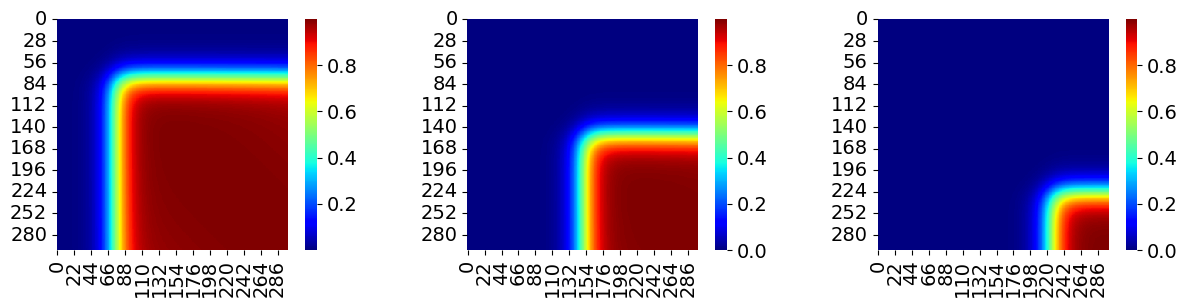

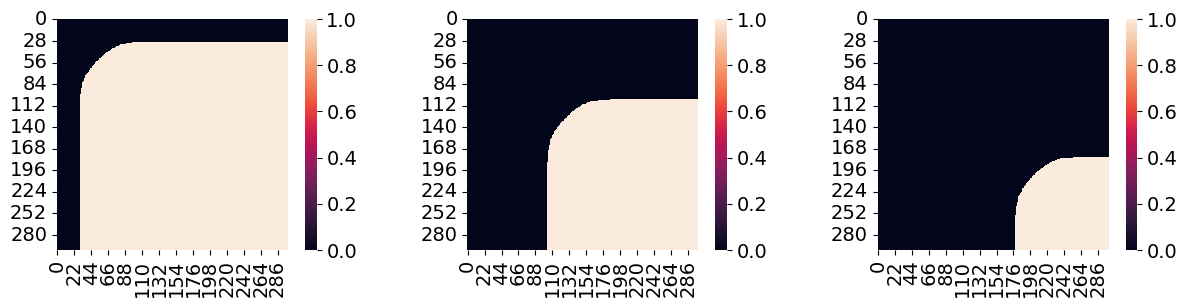

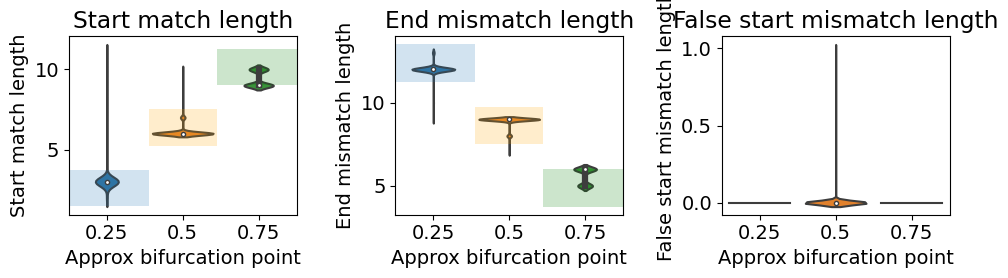

In [510]:
temp = plot_validation_stat()

Approx. convergent start i for cp=0.25 =  0.4
Approx. convergent start i for cp=0.5 =  0.65
Approx. convergent start i for cp=0.75 =  0.9
Expected match len for cp=0.25 =  [9.0, 11.25]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [1.5, 3.75]
Expected mismatch len for cp=0.25 =  [3.75, 6.0]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [11.25, 13.5]


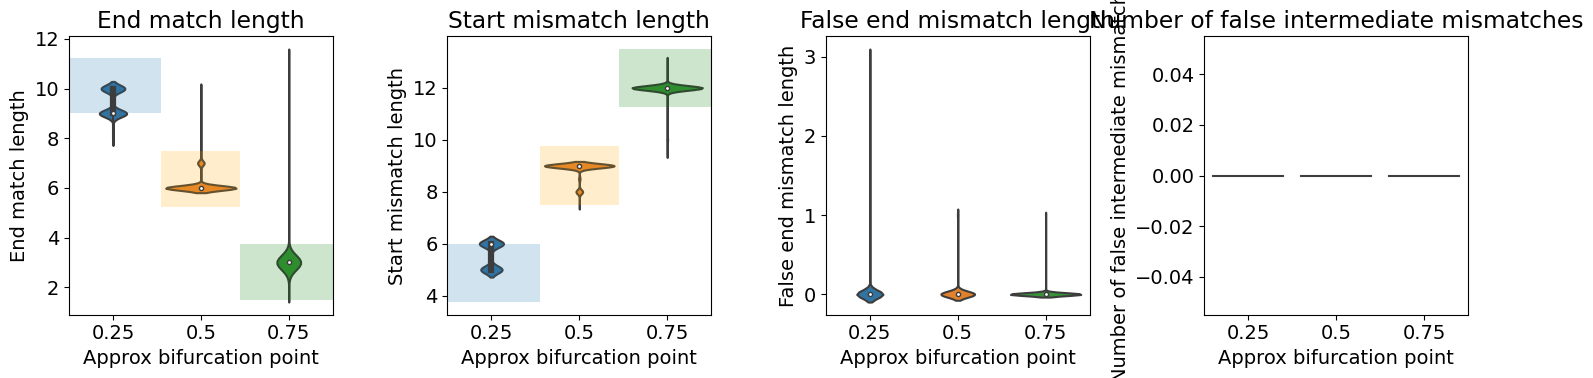

In [600]:
temp = plot_validation_stat(g2g_divcov_alignment_accuracy_results, divergence=False)

Approx. convergent start i for cp=0.25 =  0.4
Approx. convergent start i for cp=0.5 =  0.65
Approx. convergent start i for cp=0.75 =  0.9
Expected match len for cp=0.25 =  [9.0, 11.25]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [1.5, 3.75]
Expected mismatch len for cp=0.25 =  [3.75, 6.0]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [11.25, 13.5]


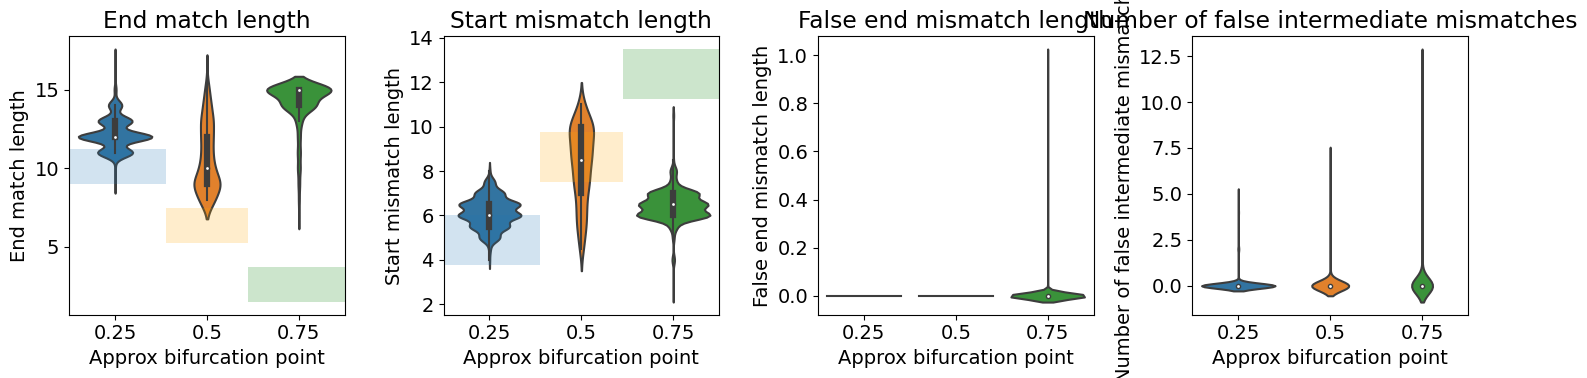

In [601]:
temp = plot_validation_stat(TrAGEDyMinCut_divcov_alignment_accuracy_results, divergence=False)

Approx. convergent start i for cp=0.25 =  0.4
Approx. convergent start i for cp=0.5 =  0.65
Approx. convergent start i for cp=0.75 =  0.9
Expected match len for cp=0.25 =  [9.0, 11.25]
Expected match len for cp=0.5 =  [5.25, 7.5]
Expected match len  for cp=0.75 =  [1.5, 3.75]
Expected mismatch len for cp=0.25 =  [3.75, 6.0]
Expected mismatch len for cp=0.5 =  [7.5, 9.75]
Expected mismatch len  for cp=0.75 =  [11.25, 13.5]


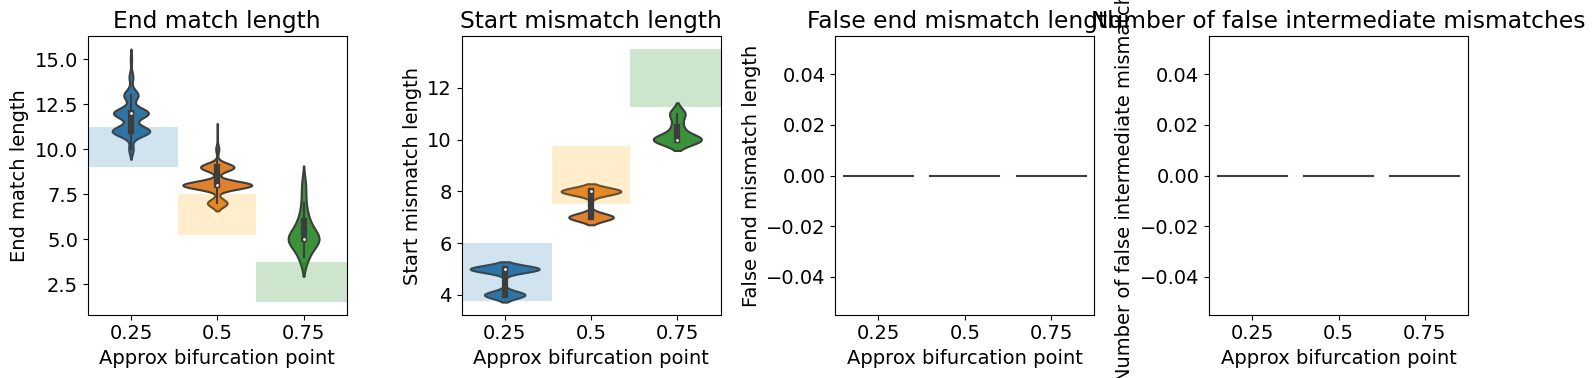

In [602]:
temp = plot_validation_stat(TrAGEDyNullCut_divcov_alignment_accuracy_results, divergence=False)

In [558]:




temp = [] 
def test(accuracy_results, method):
    
    for PATTERN in [ 'Convergence_025', 'Convergence_05', 'Convergence_075','Divergence_025', 'Divergence_05', 'Divergence_075']:
        n_tot_alignments = accuracy_results[PATTERN].shape[0]
        n_expected_patterns = accuracy_results[PATTERN][accuracy_results[PATTERN].status == 'expected_pattern'].shape[0]
        print(PATTERN,':', n_expected_patterns*100/n_tot_alignments,'%')
        temp.append( [PATTERN, method, n_expected_patterns*100/n_tot_alignments]  )

        
print('G2G ============================ ')
test(g2g_divcov_alignment_accuracy_results, method='G2G')
print('TrAGEDy min cut============================ ')
test(TrAGEDyMinCut_divcov_alignment_accuracy_results, method='TrAGEDy_mincut')
print('TrAGEDy null cut============================ ')
test(TrAGEDyNullCut_divcov_alignment_accuracy_results, method='TrAGEDy_nullcut')


temp = pd.DataFrame(temp)
temp.columns = ['Pattern','Method','% of Accurate Alignment']

fig, ax = plt.subplots(1,1,figsize=(9,3))
g = sb.barplot(
    data=temp,
    x="Pattern", y="% of accurate alignment", hue="Method",
     palette="dark", alpha=.6
)
sb.despine(bottom = False, left = False)
plt.xticks(rotation=45, ha='right')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

G2G ============================ 
Convergence_025 : 99.2 %
Convergence_05 : 98.2 %
Convergence_075 : 99.2 %
Divergence_025 : 99.4 %
Divergence_05 : 99.8 %
Divergence_075 : 100.0 %
TrAGEDy min cut============================ 
Convergence_025 : 97.35234215885947 %
Convergence_05 : 96.14604462474645 %
Convergence_075 : 88.2 %
Divergence_025 : 28.571428571428573 %
Divergence_05 : 95.86776859504133 %
Divergence_075 : 96.8586387434555 %
TrAGEDy null cut============================ 
Convergence_025 : 100.0 %
Convergence_05 : 88.0 %
Convergence_075 : 5.8 %
Divergence_025 : 5.4 %
Divergence_05 : 88.0 %
Divergence_075 : 100.0 %


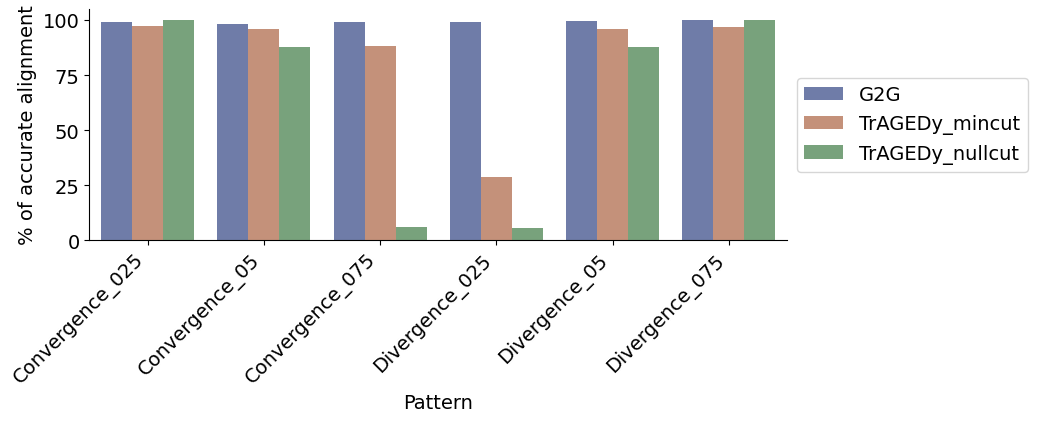

In [553]:
temp

Convergence_025  Convergence_05  Convergence_075  \
G2G                    99.200000       98.200000             99.2   
TrAGEDy_mincut         97.352342       96.146045             88.2   
TrAGEDy_nullcut       100.000000       88.000000              5.8   

                 Divergence_025  Divergence_05  Divergence_075  \
G2G                   99.400000      99.800000      100.000000   
TrAGEDy_mincut        28.571429      95.867769       96.858639   
TrAGEDy_nullcut        5.400000      88.000000      100.000000   

                          method  
G2G                          G2G  
TrAGEDy_mincut    TrAGEDy_mincut  
TrAGEDy_nullcut  TrAGEDy_nullcut

In [ ]:
g = sns.catplot(
    data=temp, kind="bar",
    x="", y="", hue="method",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

In [599]:


def plot_validation_stat(accuracy_results, n_bins = 15, divergence=True):
    
   # plt.subplots(1,3, figsize=(15,3))
   # plt.subplot(1,3,1)
   # sb.heatmap(CP_25, square=True, cmap='jet') 
   # plt.subplot(1,3,2)
   # sb.heatmap(CP_05, square=True, cmap='jet') 
   # plt.subplot(1,3,3)
   # sb.heatmap(CP_75, square=True, cmap='jet') 
    
    #plt.savefig('changepoint_kernels.pdf')

        
   # plt.subplots(1,3, figsize=(15,3))
   # plt.subplot(1,3,1)
    a = pd.DataFrame(CP_25 > 0.01) 
   # sb.heatmap(a, square=True) 
    approx_bifurcation_start_point_25 = np.min(np.where(a.iloc[299]==True))
    #approx_bifurcation_start_point_25  = np.round((0.5* approx_bifurcation_start_point_25/150) ,2)
    approx_bifurcation_start_point_25  = np.round((approx_bifurcation_start_point_25/300) ,2)


 #   plt.subplot(1,3,2)
    a = pd.DataFrame(CP_05 > 0.01) 
   # sb.heatmap(a, square=True) 
    approx_bifurcation_start_point_05 = np.min(np.where(a.iloc[299]==True)) 
    #approx_bifurcation_start_point_05 = np.round((0.5* approx_bifurcation_start_point_05/150),2)
    approx_bifurcation_start_point_05 = np.round((approx_bifurcation_start_point_05/300),2)


  #  plt.subplot(1,3,3)
    a = pd.DataFrame(CP_75 > 0.01) 
   # sb.heatmap(a, square=True) 
    approx_bifurcation_start_point_75 = np.min(np.where(a.iloc[299]==True))
    #approx_bifurcation_start_point_75  = np.round((0.5* approx_bifurcation_start_point_75/150),2)
    approx_bifurcation_start_point_75  = np.round((approx_bifurcation_start_point_75/300),2)
    
    if(divergence):
        expected_len_25 = [n_bins*approx_bifurcation_start_point_25, n_bins*0.25]
        expected_len_05 = [n_bins*approx_bifurcation_start_point_05, n_bins*0.5]
        expected_len_75 = [n_bins*approx_bifurcation_start_point_75, n_bins*0.75]

        expected_mismatch_len_25 = [n_bins*(1-0.25),n_bins*(1-approx_bifurcation_start_point_25)]
        expected_mismatch_len_05 = [n_bins*(1-0.5), n_bins*(1-approx_bifurcation_start_point_05)]
        expected_mismatch_len_75 = [n_bins*(1-0.75),n_bins*(1-approx_bifurcation_start_point_75)]
        
        y1 = 'start_match_len'
        y2 = 'end_mismatch_len'
        y3 = 'false_start_mismatch_len'
        y4 = 'n_false_intermediate_mismatches'
        
        y1_ = 'Start match length'
        y2_ = 'End mismatch length'
        y3_ = 'False start mismatch length'
        y4_ = 'Number of false intermediate mismatches'
        
        print('Approx. bifurcation start i for cp=0.25 = ', approx_bifurcation_start_point_25 )
        print('Approx. bifurcation start i for cp=0.5 = ', approx_bifurcation_start_point_05 )
        print('Approx. bifurcation start i for cp=0.75 = ', approx_bifurcation_start_point_75 )
        
            # divegence
        df_025 = accuracy_results['Divergence_025']
        df_05 = accuracy_results['Divergence_05']
        df_075 = accuracy_results['Divergence_075']
    else:
        expected_len_25 = [n_bins*(approx_bifurcation_start_point_75),n_bins*0.75]
        expected_len_75 = [n_bins*(approx_bifurcation_start_point_25),n_bins*0.25]
        expected_len_05 = [n_bins*(approx_bifurcation_start_point_05),n_bins*0.5]

        expected_mismatch_len_25 = [n_bins*(1-0.75),n_bins*(1-approx_bifurcation_start_point_75)]
        expected_mismatch_len_75 = [n_bins*(1-0.25), n_bins*(1-approx_bifurcation_start_point_25)]
        expected_mismatch_len_05 = [n_bins*(1-0.5), n_bins*(1-approx_bifurcation_start_point_05)]
        
        y1='end_match_len'
        y2= 'start_mismatch_len'
        y3='false_end_mismatch_len'
        y4 = 'n_false_intermediate_mismatches'
        
        y1_='End match length'
        y2_= 'Start mismatch length'
        y3_='False end mismatch length'
        y4_ = 'Number of false intermediate mismatches'
        
        print('Approx. convergent start i for cp=0.25 = ', 1-approx_bifurcation_start_point_75 )
        print('Approx. convergent start i for cp=0.5 = ', 1-approx_bifurcation_start_point_05 )
        print('Approx. convergent start i for cp=0.75 = ', 1-approx_bifurcation_start_point_25 )
        
        # divegence
        df_025 = accuracy_results['Convergence_025']
        df_05 = accuracy_results['Convergence_05']
        df_075 = accuracy_results['Convergence_075']

    print('Expected match len for cp=0.25 = ', expected_len_25 )
    print('Expected match len for cp=0.5 = ', expected_len_05 )
    print('Expected match len  for cp=0.75 = ', expected_len_75 )
    
    print('Expected mismatch len for cp=0.25 = ', expected_mismatch_len_25 )
    print('Expected mismatch len for cp=0.5 = ', expected_mismatch_len_05 )
    print('Expected mismatch len  for cp=0.75 = ', expected_mismatch_len_75 )

    df_075['BF_approx'] = np.repeat('0.75', len(df_075))  
    df_025['BF_approx'] = np.repeat('0.25', len(df_025))  
    df_05['BF_approx'] = np.repeat('0.5', len(df_05)) 
    df = pd.concat( [df_025, df_05, df_075])
    df = df[df.status!='complete_mismatch']
    df = df[df.status!='swapped_pattern']
    df = df[df.status!='complete_match']
    if(divergence): # because the indel length will always be twice the expected length (# of Is == # of Ds)
        df['end_mismatch_len'] = df['end_mismatch_len'] /2
    else:
        df['start_mismatch_len'] = df['start_mismatch_len'] /2

    plt.subplots(1,4, figsize=(15,4))
    plt.subplot(1,4,1)
    g = sb.violinplot(data=df,  y = y1, x='BF_approx')
    plt.xlabel('Approx bifurcation point')
    plt.title(y1_)
   # plt.ylim([0,n_bins])
    g.axhspan(expected_len_25[0], expected_len_25[1], xmin=0, xmax=0.35, alpha=0.2)
    g.axhspan(expected_len_05[0], expected_len_05[1], xmin=0.35, xmax=0.65,facecolor='orange', alpha=0.2)
    g.axhspan(expected_len_75[0], expected_len_75[1], xmin=0.65, xmax=1.0,facecolor='green', alpha=0.2)
    plt.ylabel(y1_)

    plt.subplot(1,4,2)
    g = sb.violinplot(data=df,  y = y2, x='BF_approx')
    plt.xlabel('Approx bifurcation point')
    plt.ylabel('')
  #  plt.ylim([0,n_bins])
    plt.title(y2_)
    g.axhspan(expected_mismatch_len_25[0], expected_mismatch_len_25[1], xmin=0, xmax=0.35,alpha=0.2)
    g.axhspan(expected_mismatch_len_05[0], expected_mismatch_len_05[1],xmin=0.35, xmax=0.65,facecolor='orange', alpha=0.2)
    g.axhspan(expected_mismatch_len_75[0], expected_mismatch_len_75[1],xmin=0.65, xmax=1.0,facecolor='green', alpha=0.2)
    plt.ylabel(y2_)

    plt.subplot(1,4,3)
    sb.violinplot(data=df,  y =  y3, x='BF_approx')
    plt.xlabel('Approx bifurcation point')
    plt.ylabel('')
    plt.title(y3_)
    plt.ylabel(y3_)
    
    plt.subplot(1,4,4)
    sb.violinplot(data=df,  y =  y4, x='BF_approx')
    plt.xlabel('Approx bifurcation point')
    plt.ylabel('')
    plt.title(y4_)
    plt.ylabel(y4_)
    
    plt.tight_layout()
    
    return df

In [508]:
g2g_divcov_alignment_accuracy_results['Convergence_05'].columns

Index(['status', 'false_end_mismatch_len', 'false_start_match_len',
       'end_match_len', 'n_false_intermediate_mismatches',
       'start_mismatch_len', 'alignment_str', 'gene'],
      dtype='object')